In [31]:
import numpy as np
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import mdtraj as md
import pyemma
from numba import njit,prange
import time
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [32]:
params = {
'figure.titlesize': 'xx-large',
'axes.labelsize': 'xx-large',
'axes.titlesize': 'xx-large',
'xtick.labelsize': 'xx-large',
'ytick.labelsize': 'xx-large'}
pylab.rcParams.update(params)

In [33]:
@njit
def vec_mag(vec):
    n = len(vec)
    l = 0.
    for i in range(n):
        l += (vec[i])**2.
    return np.sqrt(l)
@njit
def vec_mags(vecs):
    n = len(vecs)
    mags = np.zeros((n))
    for i in range(n):
        mags[i] = vec_mag(vecs[i])
    return mags

@njit
def vec_norm(vec):
    return vec / vec_mag(vec)

@njit
def vec_norms(vecs):
    n = len(vecs)
    norms = np.zeros((vecs.shape))
    for i in range(n):
        norms[i] = vec_norm(vecs[i])
    return norms

@njit
def ndot(a, b):
    n = len(a)
    s = 0.
    for i in range(n):
        s += a[i] * b[i]
    return s

@njit 
def ndots(vecs1, vecs2):
    #assert len(vecs1) == len(vecs2)
    n = len(vecs1)
    dots = np.zeros((n))
    for i in range(n):
        dots[i] = ndot(vecs1[i], vecs2[i])
    return dots

@njit
def cross_product(xyz1, xyz2):
    cross = np.zeros((3))
    cross[0] = xyz1[1]*xyz2[2] - xyz1[2]*xyz2[1]
    cross[1] = xyz1[2]*xyz2[0] - xyz1[0]*xyz2[2]
    cross[2] = xyz1[0]*xyz2[1] - xyz1[1]*xyz2[0]
    return cross

@njit
def cross_products(xyzs1, xyzs2):
    n = xyzs1.shape[0]
    cross = np.zeros((n, 3))
    for i in range(n):
        cross[i] = cross_product(xyzs1[i], xyzs2[i])
    return cross

@njit
def unravel_index(n1, n2):
    a, b = np.empty((n1, n2), dtype=np.int64), np.empty((n1, n2), dtype=np.int64)
    for i in range(n1):
        for j in range(n2):
            a[i,j], b[i,j] = i, j
    return a.ravel(),b.ravel()

@njit
def dist_mat(xyz1, xyz2):
    n1 = xyz1.shape[0]
    n2 = xyz2.shape[0]
    ndim = xyz1.shape[1]
    dist_mat = np.zeros((n1 * n2))
    i, j = unravel_index(n1, n2)
    for k in range(n1 * n2):
        dr = xyz1[i[k]] - xyz2[j[k]]
        for ri in range(ndim):
            dist_mat[k] += np.square(dr[ri])
    return np.sqrt(dist_mat)

@njit
def min_dist(xyz1, xyz2):
    dists = dist_mat(xyz1, xyz2)
    return np.min(dists)

@njit
def min_dists(xyzs1, xyzs2):
    n = xyzs1.shape[0]
    mins = np.zeros((n))
    for i in range(n):
        mins[i] = min_dist(xyzs1[i],xyzs2[i])
    return mins

@njit
def unravel_upper_triangle_index(n):
    n_unique = (n * (n-1)) // 2
    a, b = np.empty((n_unique),dtype=np.int64), np.empty((n_unique),dtype=np.int64)
    k = 0
    for i in range(n):
        for j in range(n):
            if i < j:
                a[k], b[k] = i, j
                k += 1
    return a, b

@njit#(parallel=True)
def sym_dist_mat(xyzs):
    n = xyzs.shape[0]
    n_unique = (n * (n-1)) // 2
    ndim = xyzs.shape[1]
    i, j = unravel_upper_triangle_index(n)
    dist_mat = np.zeros((n_unique))
    for k in range(n_unique):
        for ri in range(ndim):
            dist_mat[k] += np.square(xyzs[i[k],ri] - xyzs[j[k],ri])
    return np.sqrt(dist_mat)

@njit
def sym_dist_mats(xyzss):
    n_frames = xyzss.shape[0]
    n_atoms  = xyzss.shape[1]
    n_unique = (n_atoms * (n_atoms-1)) // 2
    dist_mats = np.zeros((n_frames, n_unique))
    for i in range(n_frames):
        dist_mats[i] = sym_dist_mat(xyzss[i])
    return dist_mats

@njit(parallel=True)
def p_sym_dist_mats(xyzss):
    n_frames = xyzss.shape[0]
    n_atoms  = xyzss.shape[1]
    n_unique = (n_atoms * (n_atoms-1)) // 2
    dist_mats = np.zeros((n_frames, n_unique))
    for i in prange(n_frames):
        dist_mats[i] = sym_dist_mat(xyzss[i])
    return dist_mats

## 4mer conformer extraction $\downarrow$

In [34]:
home = '/path/to/dir'
dirnames  = ['gly/MGGM',
             'ala/MAAM',
             'tyr/MYYM',
             'trp/MWWM',
             'pro/MPPM']
peptides  = [dirname.split('/')[0] for dirname in dirnames] # gly, ala, tyr, trp, pro
sequences = [dirname.split('/')[1] for dirname in dirnames] # MGGM,MAAM,MYYM,MWWM,MPPM
systems   = ['hold-orient-efieldall-6',
             'hold-orient-efieldall-9',
             'hold-orient-efieldall-12']
holds = [6, 9, 12]
n_reps = 16
n_residues = 4
last_n_frames = 47500 # last 190 ns of each rep
rad_to_deg = 180. / np.pi
traj_files = [[['%s/%s/%s/strip_%i.dcd'%(home,dirname,system,rep) 
                for rep in range(n_reps)] 
               for system in systems] 
              for dirname in dirnames]
top_files = ['%s/%s/build/strip.psf'%(home,dirname) 
             for dirname in dirnames]

In [35]:
trajs = []
for i,dirname in enumerate(dirnames):
    traji = []
    for j,system in enumerate(systems):
        trajij = []
        for rep in range(n_reps):
            trajij.append(md.load(traj_files[i][j][rep], top=top_files[i])[-last_n_frames:])
        traji.append(md.join(trajij))
    trajs.append(traji)

In [36]:
for trajgroup in trajs:
    assert trajgroup[0].n_frames == trajgroup[1].n_frames == trajgroup[2].n_frames 
n_frames = trajs[0][0].n_frames

In [37]:
# i -> i+3 H-bond distance

hbond_dist_sel = ['resid 0 and name O',
                  'resid 3 and name H']

hbond_dist_inds = [[[trajs[i][j].top.select(sel)[0] 
                     for sel in hbond_dist_sel] 
                    for j in range(len(systems))] 
                   for i in range(len(dirnames))]

hbond_dists = 10. * np.array([[np.sqrt(np.sum(np.square(trajs[i][j].xyz[:,hbond_dist_inds[i][j][0]] - trajs[i][j].xyz[:,hbond_dist_inds[i][j][1]]),axis=1)) 
                               for j in range(len(systems))] 
                              for i in range(len(dirnames))])

In [38]:
# inter-terminus distance

termi_dist_sel = ['resid 0 and name N',
                  'resid 3 and name C']

termi_dist_inds = [[[trajs[i][j].top.select(sel)[0] 
                     for sel in termi_dist_sel] 
                    for j in range(len(systems))] 
                   for i in range(len(dirnames))]

termi_dists = 10. * np.array([[np.sqrt(np.sum(np.square(trajs[i][j].xyz[:,termi_dist_inds[i][j][0]] - trajs[i][j].xyz[:,termi_dist_inds[i][j][1]]),axis=1)) 
                               for j in range(len(systems))] 
                              for i in range(len(dirnames))])

In [66]:
angle_atomnames = ['CE', 'SD', 'CG']
p1_angle_inds = [[[trajs[i][j].top.select('resid 0 and name %s'%atomname) 
                   for atomname in angle_atomnames] 
                  for j in range(len(systems))] 
                 for i in range(len(dirnames))]
p2_angle_inds = [[[trajs[i][j].top.select('resid 3 and name %s'%atomname) 
                   for atomname in angle_atomnames] 
                  for j in range(len(systems))] 
                 for i in range(len(dirnames))]

p1_dotz = np.array([[vec_norms((trajs[i][j].xyz[:,p1_angle_inds[i][j][1]] - 0.5*(trajs[i][j].xyz[:,p1_angle_inds[i][j][2]] + trajs[i][j].xyz[:,p1_angle_inds[i][j][0]])).reshape(n_frames,3))[:,2] 
                     for j in range(len(systems))] 
                    for i in range(len(dirnames))])
p2_dotz = np.array([[vec_norms((trajs[i][j].xyz[:,p2_angle_inds[i][j][1]] - 0.5*(trajs[i][j].xyz[:,p2_angle_inds[i][j][2]] + trajs[i][j].xyz[:,p2_angle_inds[i][j][0]])).reshape(n_frames,3))[:,2] 
                     for j in range(len(systems))] 
                    for i in range(len(dirnames))])

<IPython.core.display.Javascript object>


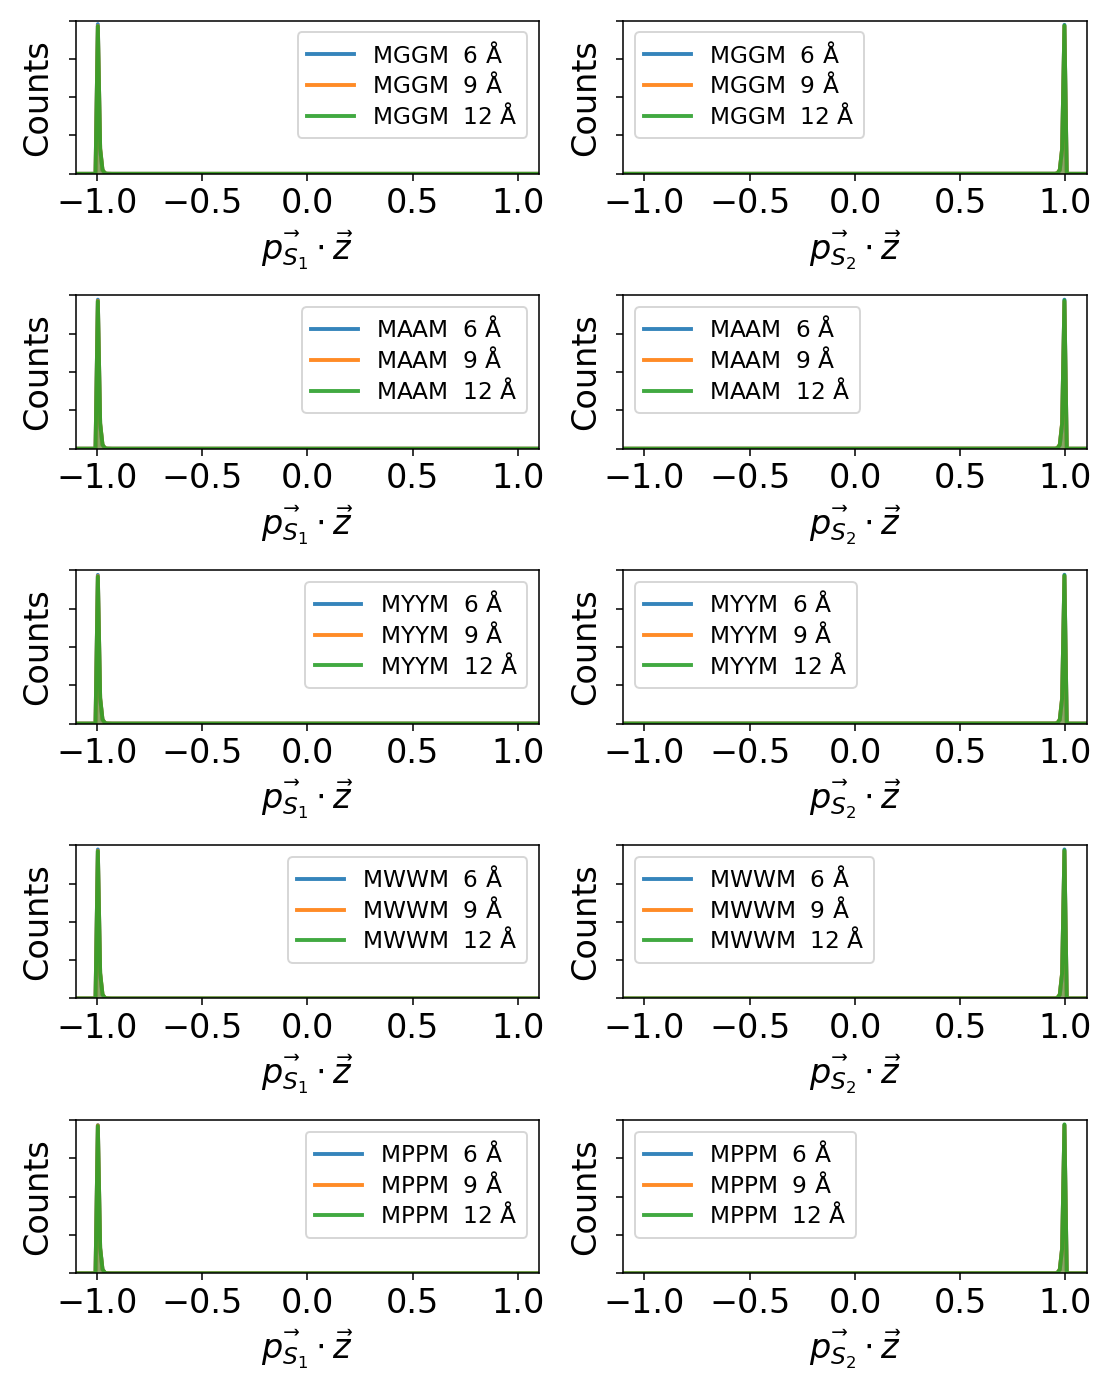

In [91]:
%matplotlib notebook
pylab.rcParams.update({'figure.figsize': (8,10)})
nbins=200
xlim=[-1.1,1.1]
binc= 0.5 * (np.linspace(xlim[0],xlim[1],nbins)[1:] + np.linspace(xlim[0],xlim[1],nbins)[:-1])
#xlabel=r'$\{p_{S_{i}}} \cdot \vec{z}$'
labels = [r' %i $\mathrm{\AA}$'%(hold) for hold in (6,9,12)]
xticks=[-1,-.5,0,.5,1]

maxy_ij = 0
fig, ax = plt.subplots(len(dirnames), 2)
for i in range(len(dirnames)):
    for j in range(len(systems)):
        # plot hist and save bin heights
        binh,_,_ = ax[i,0].hist(p1_dotz[i,j], alpha=0.4, color='C%i'%j,
                              bins=np.linspace(xlim[0],xlim[1],nbins))
        maxy_ij = np.array([maxy_ij, binh.max()]).max()
        # plot bin heights as line
        ax[i,0].plot(binc, binh, color='C%i'%j, alpha=0.9, linewidth=2,
                   label=r'%s %s'%(sequences[i],labels[j]))
        ax[i,0].legend(fontsize='large', labelspacing=0.2)
        
        # plot hist and save bin heights
        binh,_,_ = ax[i,1].hist(p2_dotz[i,j], alpha=0.4, color='C%i'%j,
                              bins=np.linspace(xlim[0],xlim[1],nbins))
        maxy_ij = np.array([maxy_ij, binh.max()]).max()
        # plot bin heights as line
        ax[i,1].plot(binc, binh, color='C%i'%j, alpha=0.9, linewidth=2,
                   label=r'%s %s'%(sequences[i],labels[j]))
        ax[i,1].legend(fontsize='large', labelspacing=0.2)

    ax[i,0].set_xlabel(r'$\vec{p_{S_{1}}} \cdot \vec{z}$')
    ax[i,0].set_ylabel('Counts')
    ax[i,0].set_xlim(xlim)
    ax[i,0].set_xticks(xticks)
    #ax[i,0].set_yticks([])
    
    ax[i,1].set_xlabel(r'$\vec{p_{S_{2}}} \cdot \vec{z}$')
    ax[i,1].set_ylabel('Counts')
    ax[i,1].set_xlim(xlim)
    ax[i,1].set_xticks(xticks)
    #ax[i,1].set_yticks([])
for i in range(len(dirnames)):
    for j in range(2):
        ax[i,j].set_ylim(0, maxy_ij+15000)
        ax[i,j].set_yticks(np.linspace(0,maxy_ij+15000,5))
        ax[i,j].set_yticklabels([])
        #ax[i,j].semilogy()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


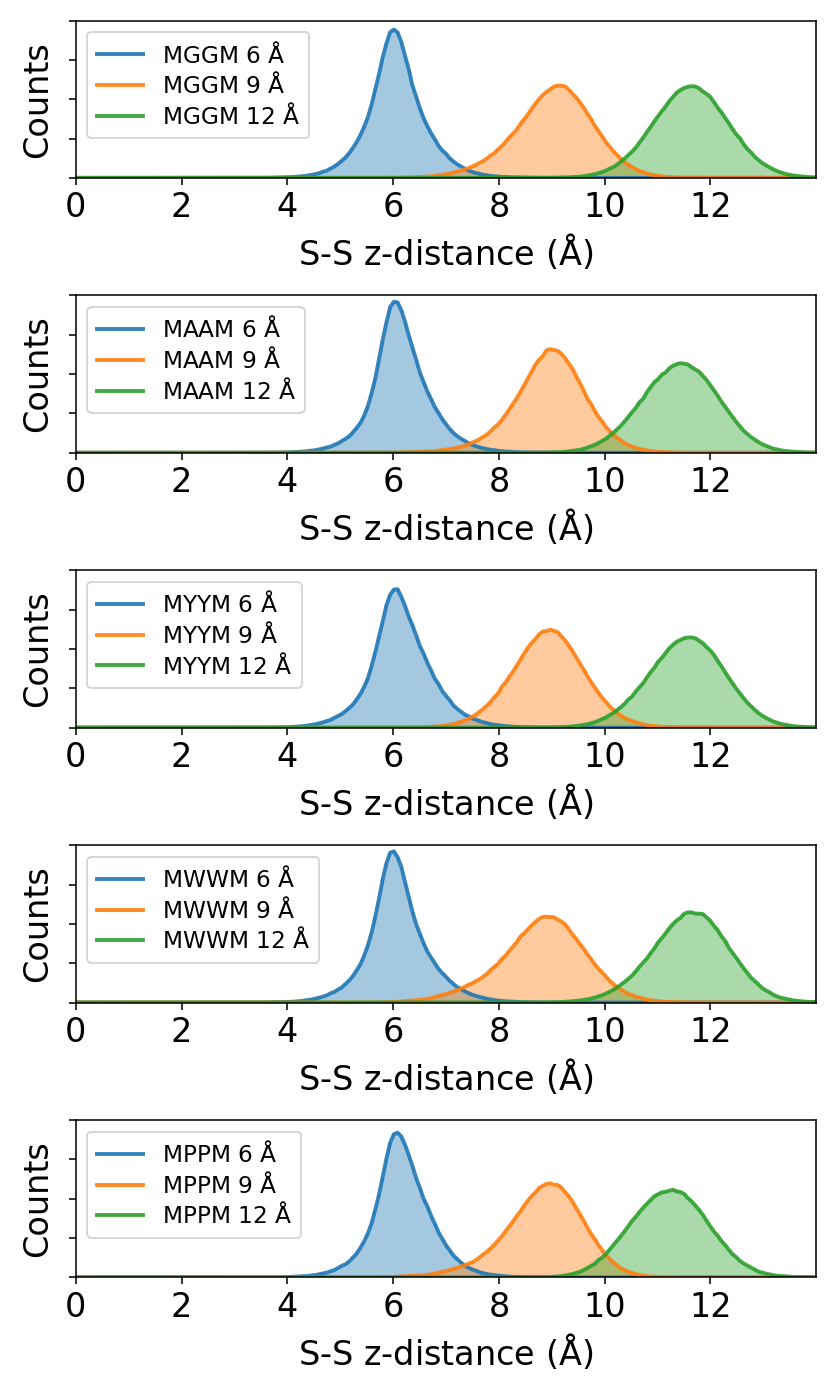

In [41]:
%matplotlib notebook
pylab.rcParams.update({'figure.figsize': (6,10)})
nbins=200
xlim=[0,14]
binc= 0.5 * (np.linspace(xlim[0],xlim[1],nbins)[1:] + np.linspace(xlim[0],xlim[1],nbins)[:-1])
xlabel=r'S-S z-distance ($\mathrm{\AA}$)'
labels = [r' %i $\mathrm{\AA}$'%(hold) for hold in (6,9,12)]
xticks=[0,2,4,6,8,10,12]

maxy_ij = 0
fig, ax = plt.subplots(len(dirnames))
for i in range(len(dirnames)):
    for j in range(len(systems)):
        # plot hist and save bin heights
        binh,_,_ = ax[i].hist(s_zdists[i,j], alpha=0.4, color='C%i'%j,
                              bins=np.linspace(xlim[0],xlim[1],nbins))
        maxy_ij = np.array([maxy_ij, binh.max()]).max()
        # plot bin heights as line
        ax[i].plot(binc, binh, color='C%i'%j, alpha=0.9, linewidth=2,
                   label=sequences[i]+labels[j])
        ax[i].legend(fontsize='large', labelspacing=0.2)

    ax[i].set_xlabel(xlabel)
    ax[i].set_ylabel('Counts')
    ax[i].set_xlim(xlim)
    ax[i].set_xticks(xticks)
    ax[i].set_yticks([])
for i in range(len(dirnames)):
    ax[i].set_ylim(0, maxy_ij+2000)
    ax[i].set_yticks(np.linspace(0,maxy_ij+2000,5))
    ax[i].set_yticklabels([])
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


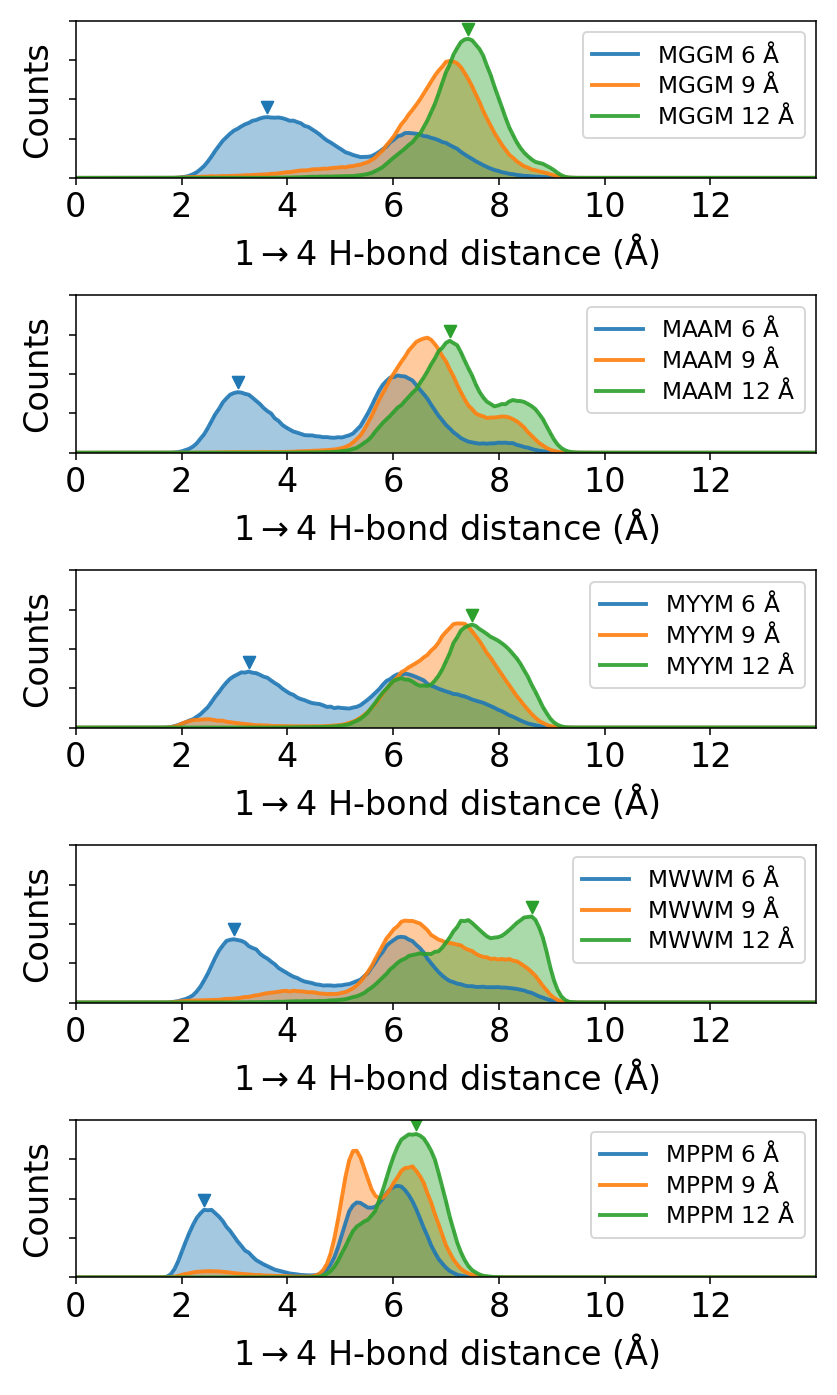

In [43]:
%matplotlib notebook
pylab.rcParams.update({'figure.figsize': (6,10)})
nbins=200
xlim=[0,14]
binc= 0.5 * (np.linspace(xlim[0],xlim[1],nbins)[1:] + np.linspace(xlim[0],xlim[1],nbins)[:-1])
xlabel=r'1$\rightarrow$4 H-bond distance ($\mathrm{\AA}$)'
labels = [r' %i $\mathrm{\AA}$'%(hold) for hold in (6,9,12)]
xticks=[0,2,4,6,8,10,12]

hold6_dists  = np.zeros((len(dirnames), 2))
hold12_dists = np.zeros((len(dirnames)))

maxy_ij = 0
fig, ax = plt.subplots(len(dirnames))
for i in range(len(dirnames)):
    for j in range(len(systems)):
        # plot hist and save bin heights
        binh,_,_ = ax[i].hist(hbond_dists[i,j], alpha=0.4, color='C%i'%j,
                              bins=np.linspace(xlim[0],xlim[1],nbins))
        maxy_ij = np.array([maxy_ij, binh.max()]).max()
        # plot bin heights as line
        ax[i].plot(binc, binh, color='C%i'%j, alpha=0.9, linewidth=2,
                   label=sequences[i]+labels[j])
        ax[i].legend(fontsize='large', labelspacing=0.2)
        # find peaks and plot as X
        if j != 1:
            peakids = find_peaks(binh, distance=11, prominence=5000)[0]
            ax[i].scatter(binc[peakids[0]],binh[peakids[0]]+2500,c='C%i'%j,marker='v')
        # save peak positions for holding stages 6 and 12
        if j == 0:
            hold6_dists[i]  = binc[peakids]
        elif j == 2:
            hold12_dists[i] = binc[peakids]
    ax[i].set_xlabel(xlabel)
    ax[i].set_ylabel('Counts')
    ax[i].set_xlim(xlim)
    ax[i].set_xticks(xticks)
for i in range(len(dirnames)):
    ax[i].set_ylim(0,maxy_ij+3500)
    ax[i].set_yticks(np.linspace(0,maxy_ij+3500,5))
    ax[i].set_yticklabels([])
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


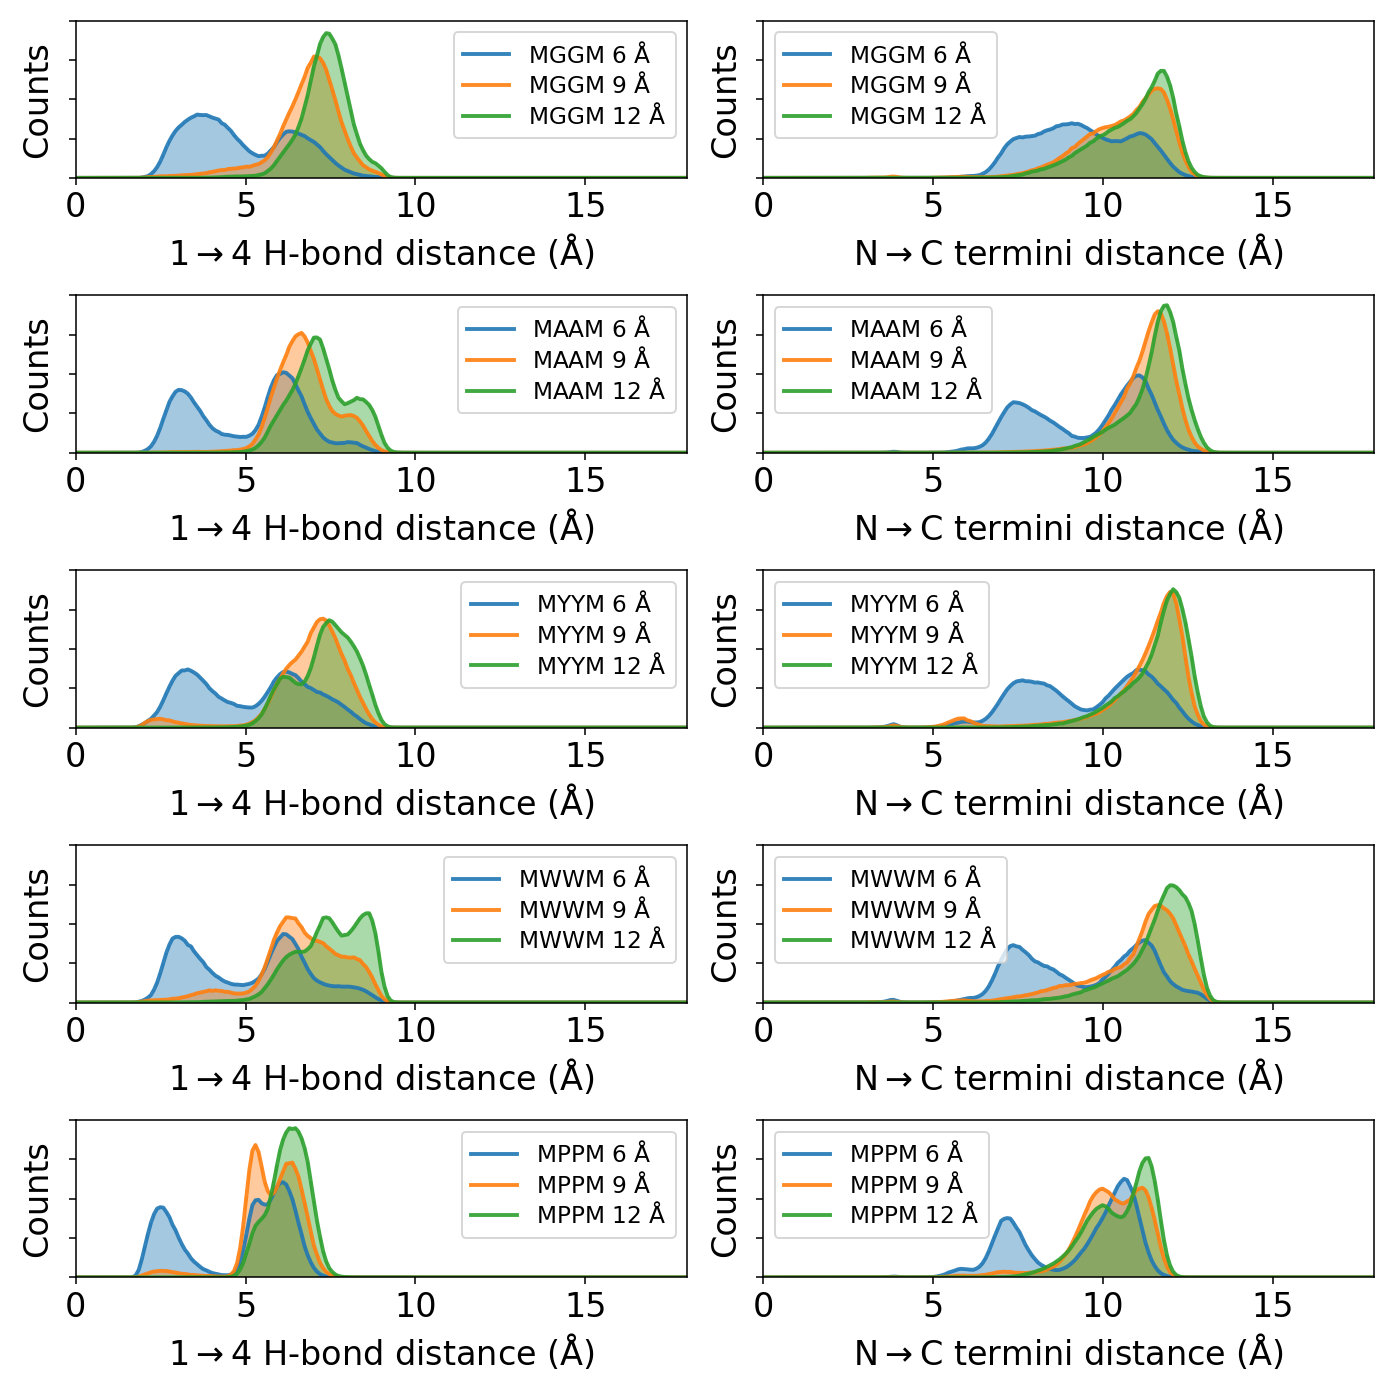

In [45]:
%matplotlib notebook
pylab.rcParams.update({'figure.figsize': (10,10)})
nbins = 200
xlim = [0,18]
dist_list = [hbond_dists, termi_dists]
#ang_list = [hbond_14_angles, hbond_25_angles, hbond_15_angles]
xlabels = [r'1$\rightarrow$4 H-bond distance ($\mathrm{\AA}$)',
           r'N$\rightarrow$C termini distance ($\mathrm{\AA}$)']
labels = [r' %i $\mathrm{\AA}$'%(hold) for hold in (6,9,12)]

maxy_ij = 0
fig, ax = plt.subplots(len(dirnames), len(dist_list))
for i in range(len(dirnames)):
    for j in range(len(dist_list)):
        for k in range(len(systems)):
            binh,bine,_ = ax[i,j].hist(dist_list[j][i,k], alpha=0.4,
                                       bins=np.linspace(xlim[0],xlim[1],nbins),color='C%i'%k)
            maxy_ij = np.array([maxy_ij, binh.max()]).max()
            # get center of each bin and plot as line
            binc = 0.5 * (bine[1:] + bine[:-1])
            ax[i,j].plot(binc, binh, color='C%i'%k, 
                         label=sequences[i]+labels[k], linewidth=2, alpha=0.9)
            ax[i,j].legend(fontsize='large', labelspacing=.2)
        ax[i,j].set_xlabel(xlabels[j])
        ax[i,j].set_xlim(xlim)
        ax[i,j].set_ylabel('Counts')
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i,j].set_yticks(np.linspace(0,maxy_ij+2500,5))
        ax[i,j].set_yticklabels([])
        ax[i,j].set_ylim(0,maxy_ij+2500)
plt.tight_layout()
plt.show()

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [47]:
bb_sel = 'backbone or name OXT'
bb_inds = [trajs[i][0].top.select(bb_sel) 
           for i in range(len(dirnames))]
n_bb = len(bb_inds[0])
n_unique = (n_bb*(n_bb-1))//2
print('%i shared backbone atoms, %i unique pairwise distances'%(n_bb, n_unique))

17 shared backbone atoms, 136 unique pairwise distances


In [48]:
# verify ordering of backbone atoms
for i in range(len(dirnames)):
    bb_atom_names = [atom.name for atom in trajs[i][0].atom_slice(bb_inds[i]).top.atoms]
    print(bb_atom_names)

['N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'OXT']
['N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'OXT']
['N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'OXT']
['N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'OXT']
['N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'OXT']


In [49]:
n_residues

4

In [50]:
for i in range(n_bb):
    bb_per_res = (n_bb - 1)/n_residues
    res_id = int(i/bb_per_res) if i != n_bb - 1 else n_residues-1
    bb_atom_names[i] += str(res_id+1)
bb_atom_names

['N1',
 'CA1',
 'C1',
 'O1',
 'N2',
 'CA2',
 'C2',
 'O2',
 'N3',
 'CA3',
 'C3',
 'O3',
 'N4',
 'CA4',
 'C4',
 'O4',
 'OXT4']

In [51]:
# assign pair labels
bb_pair_i, bb_pair_j = unravel_upper_triangle_index(n_bb)
bb_pair_labels = []
for i in range(n_unique):
    bb_pair_labels.append('%s-%s'%(bb_atom_names[bb_pair_i[i]], bb_atom_names[bb_pair_j[i]]))
bb_pair_labels

['N1-CA1',
 'N1-C1',
 'N1-O1',
 'N1-N2',
 'N1-CA2',
 'N1-C2',
 'N1-O2',
 'N1-N3',
 'N1-CA3',
 'N1-C3',
 'N1-O3',
 'N1-N4',
 'N1-CA4',
 'N1-C4',
 'N1-O4',
 'N1-OXT4',
 'CA1-C1',
 'CA1-O1',
 'CA1-N2',
 'CA1-CA2',
 'CA1-C2',
 'CA1-O2',
 'CA1-N3',
 'CA1-CA3',
 'CA1-C3',
 'CA1-O3',
 'CA1-N4',
 'CA1-CA4',
 'CA1-C4',
 'CA1-O4',
 'CA1-OXT4',
 'C1-O1',
 'C1-N2',
 'C1-CA2',
 'C1-C2',
 'C1-O2',
 'C1-N3',
 'C1-CA3',
 'C1-C3',
 'C1-O3',
 'C1-N4',
 'C1-CA4',
 'C1-C4',
 'C1-O4',
 'C1-OXT4',
 'O1-N2',
 'O1-CA2',
 'O1-C2',
 'O1-O2',
 'O1-N3',
 'O1-CA3',
 'O1-C3',
 'O1-O3',
 'O1-N4',
 'O1-CA4',
 'O1-C4',
 'O1-O4',
 'O1-OXT4',
 'N2-CA2',
 'N2-C2',
 'N2-O2',
 'N2-N3',
 'N2-CA3',
 'N2-C3',
 'N2-O3',
 'N2-N4',
 'N2-CA4',
 'N2-C4',
 'N2-O4',
 'N2-OXT4',
 'CA2-C2',
 'CA2-O2',
 'CA2-N3',
 'CA2-CA3',
 'CA2-C3',
 'CA2-O3',
 'CA2-N4',
 'CA2-CA4',
 'CA2-C4',
 'CA2-O4',
 'CA2-OXT4',
 'C2-O2',
 'C2-N3',
 'C2-CA3',
 'C2-C3',
 'C2-O3',
 'C2-N4',
 'C2-CA4',
 'C2-C4',
 'C2-O4',
 'C2-OXT4',
 'O2-N3',
 'O2-CA3',
 'O2-C3',

In [52]:
# calculate E.D.M for each system using only shared backbone atoms
start = time.time()
bb_distmats = np.zeros((len(dirnames), len(systems), n_frames, n_unique))
for i in range(len(dirnames)):
    for j in range(len(systems)):
        bb_distmats[i,j] = p_sym_dist_mats(trajs[i][j].xyz[:,bb_inds[i]])
end = time.time()
bb_distmats *= 10.
print('%.2f seconds runtime for %.2E distances (%.2E seconds per distance)'%((end-start), len(bb_distmats.ravel()), (end-start)/len(bb_distmats.ravel())))

21.80 seconds runtime for 1.55E+09 distances (1.41E-08 seconds per distance)


In [53]:
# reshape and scale training data
scaler = StandardScaler()
X_train = bb_distmats.reshape(np.product(bb_distmats.shape[:-1]),-1)
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)

In [54]:
pca_model = PCA(n_components=5,
                whiten=True)
#X_train = bb_distmats.reshape(np.product(bb_distmats.shape[:-1]),-1)
pca_model.fit(X_train_scale)

PCA(n_components=5, whiten=True)

In [55]:
pcs = np.zeros((len(dirnames), len(systems), n_frames, 5))
for i in range(len(dirnames)):
    for j in range(len(systems)):
        pcs[i,j] = pca_model.transform(scaler.transform(bb_distmats[i,j]))

In [56]:
pca_model.explained_variance_ratio_

array([0.26600859, 0.10175725, 0.05781292, 0.05247404, 0.04323982])

<IPython.core.display.Javascript object>


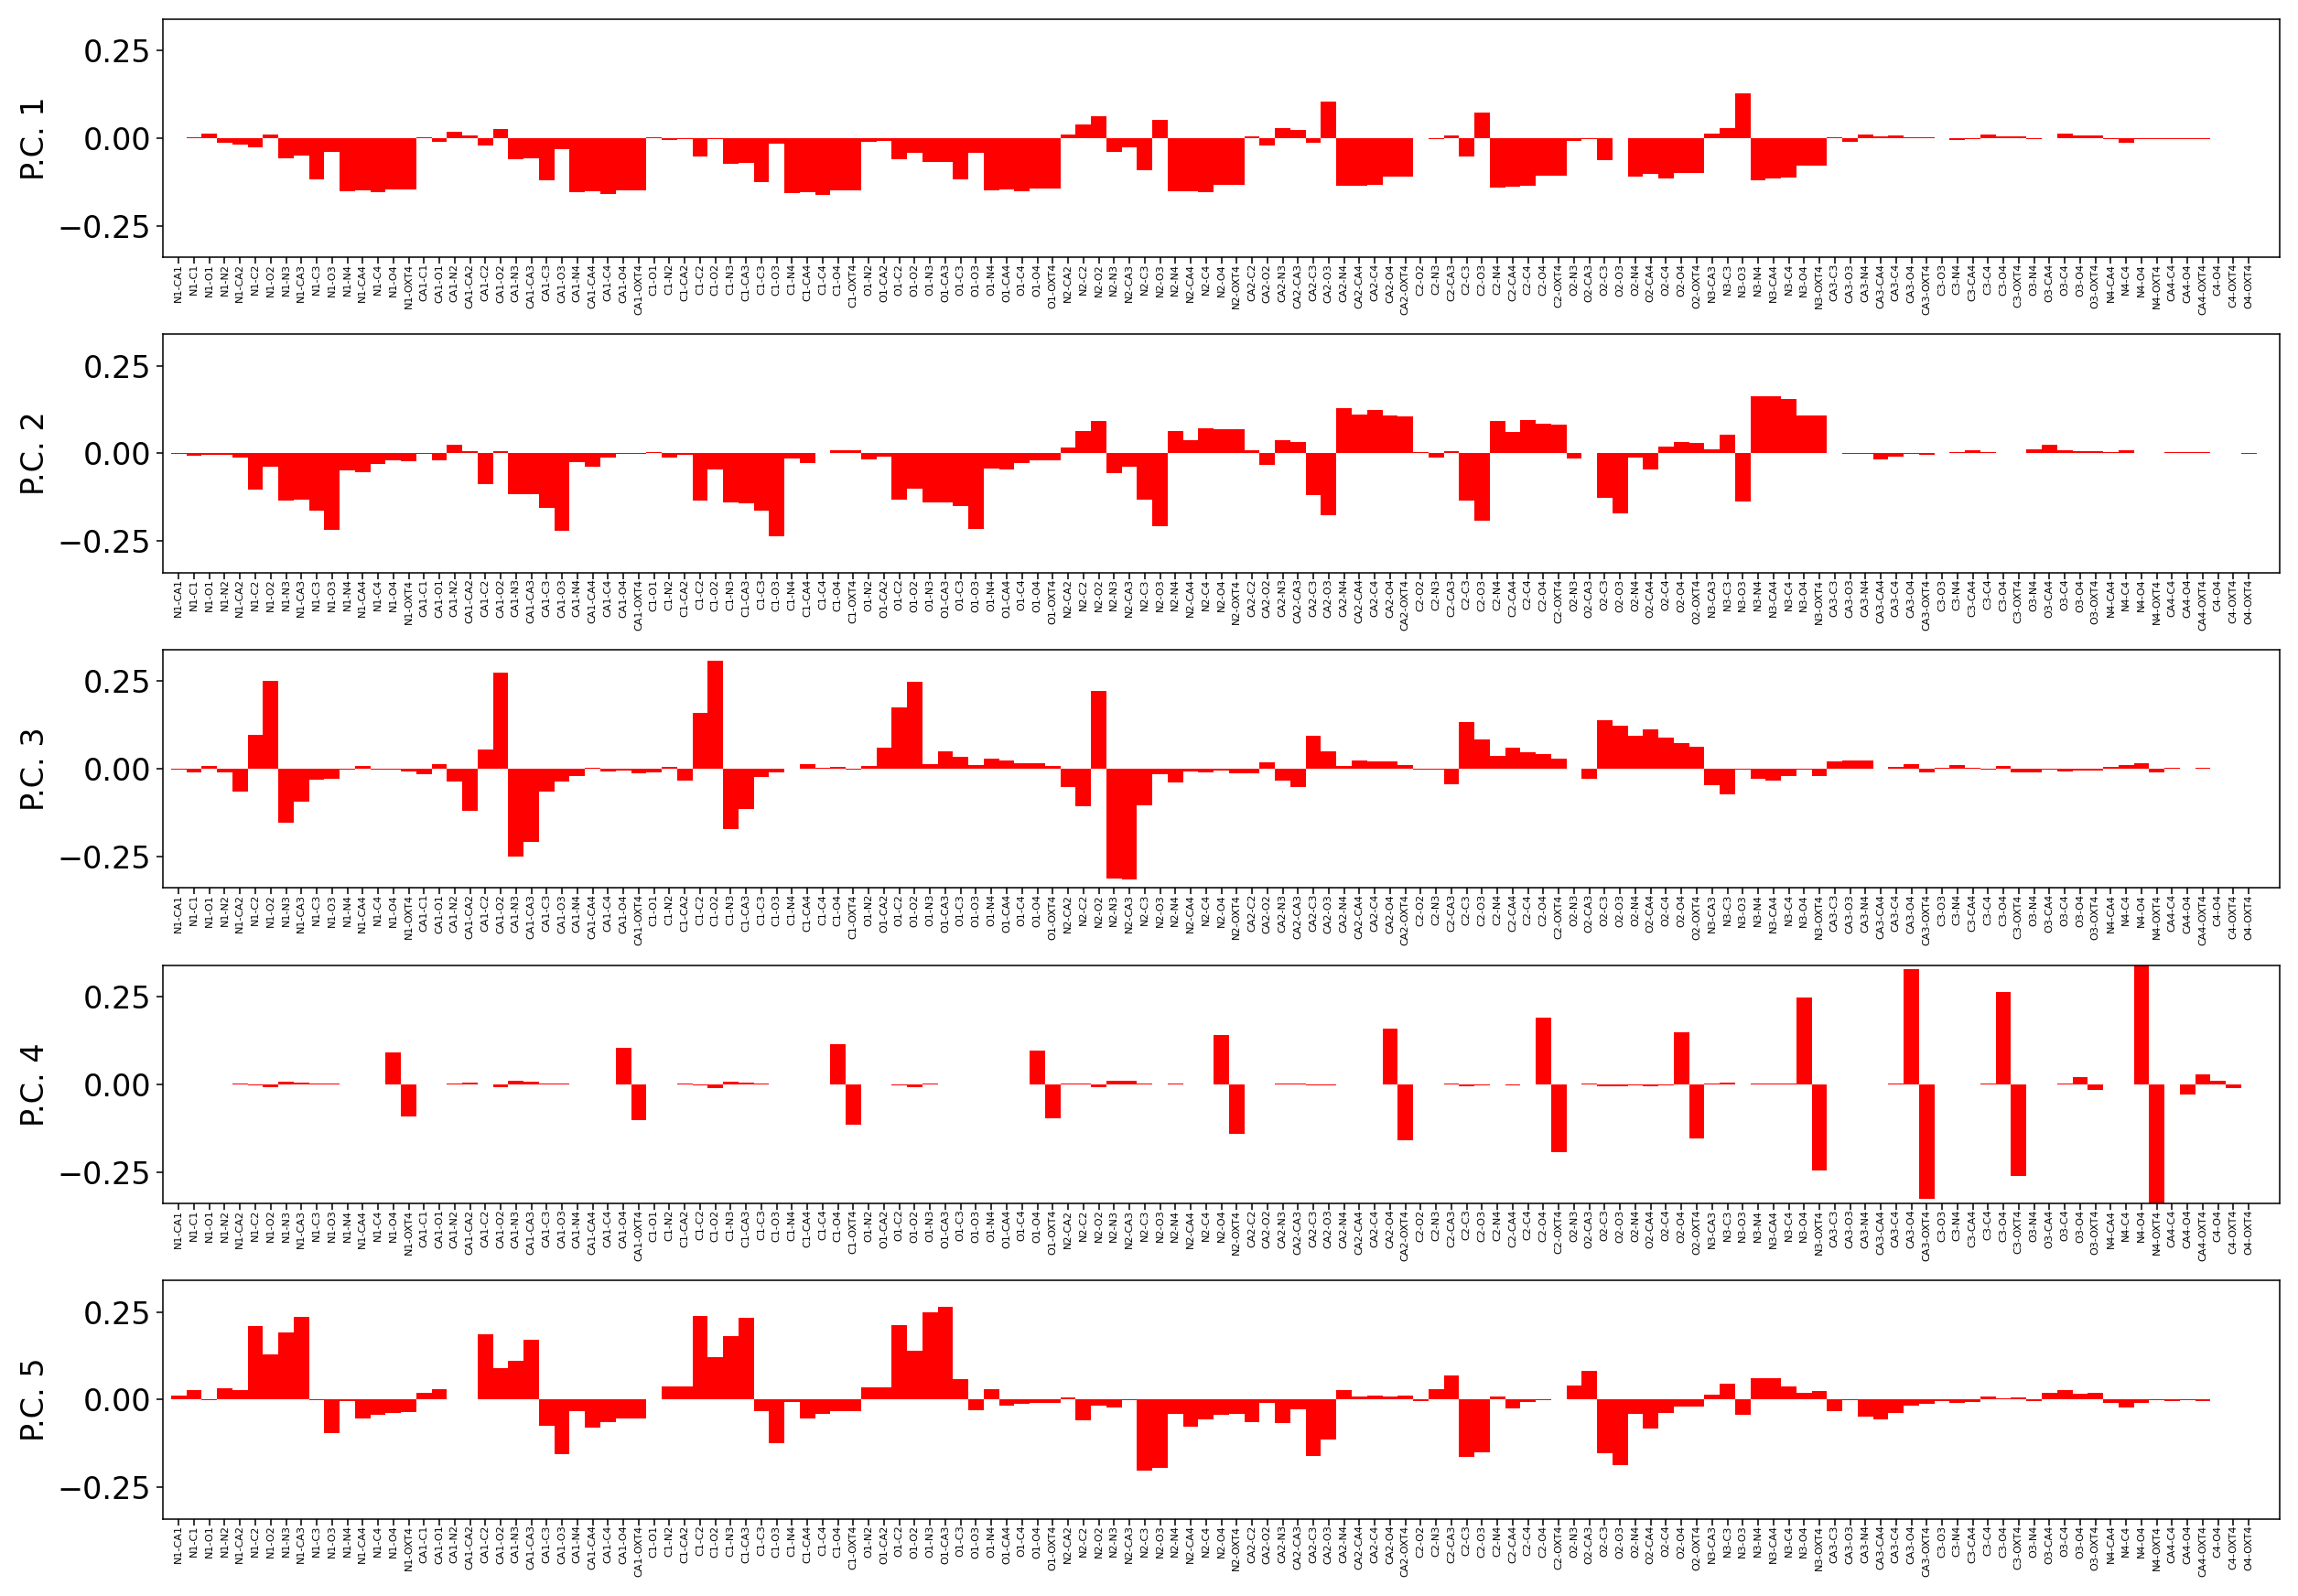

In [92]:
%matplotlib notebook
pylab.rcParams.update({'figure.figsize': (18,pca_model.n_components_*2.5)})
n_comp = pca_model.components_.shape[0]
ylim = pca_model.components_.min(), pca_model.components_.max()
fig, ax = plt.subplots(n_comp)
for i in range(n_comp):
    ax[i].bar(np.arange(n_unique), pca_model.components_[i], 1, tick_label=bb_pair_labels, color='red')
    ax[i].set_xlim(-1,n_unique+1)
    #for j in range(n_unique):
    #    ax[i].bar(j, pca_model.components_[i,j], 1, color='red', tick_label=bb_pair_labels[j])
    #    #ax[i].set_xlim(-1,n_unique+1)
    ax[i].set_ylim(ylim)
    ax[i].set_ylabel('P.C. %i'%(i+1))
for i in range(n_comp):
    for label in ax[i].get_xticklabels():
        label.set_rotation(90)
        label.set_ha('center')
        label.set_fontsize('xx-small')
    for tick in ax[i].get_xaxis().get_major_ticks():
        tick.set_pad(0)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


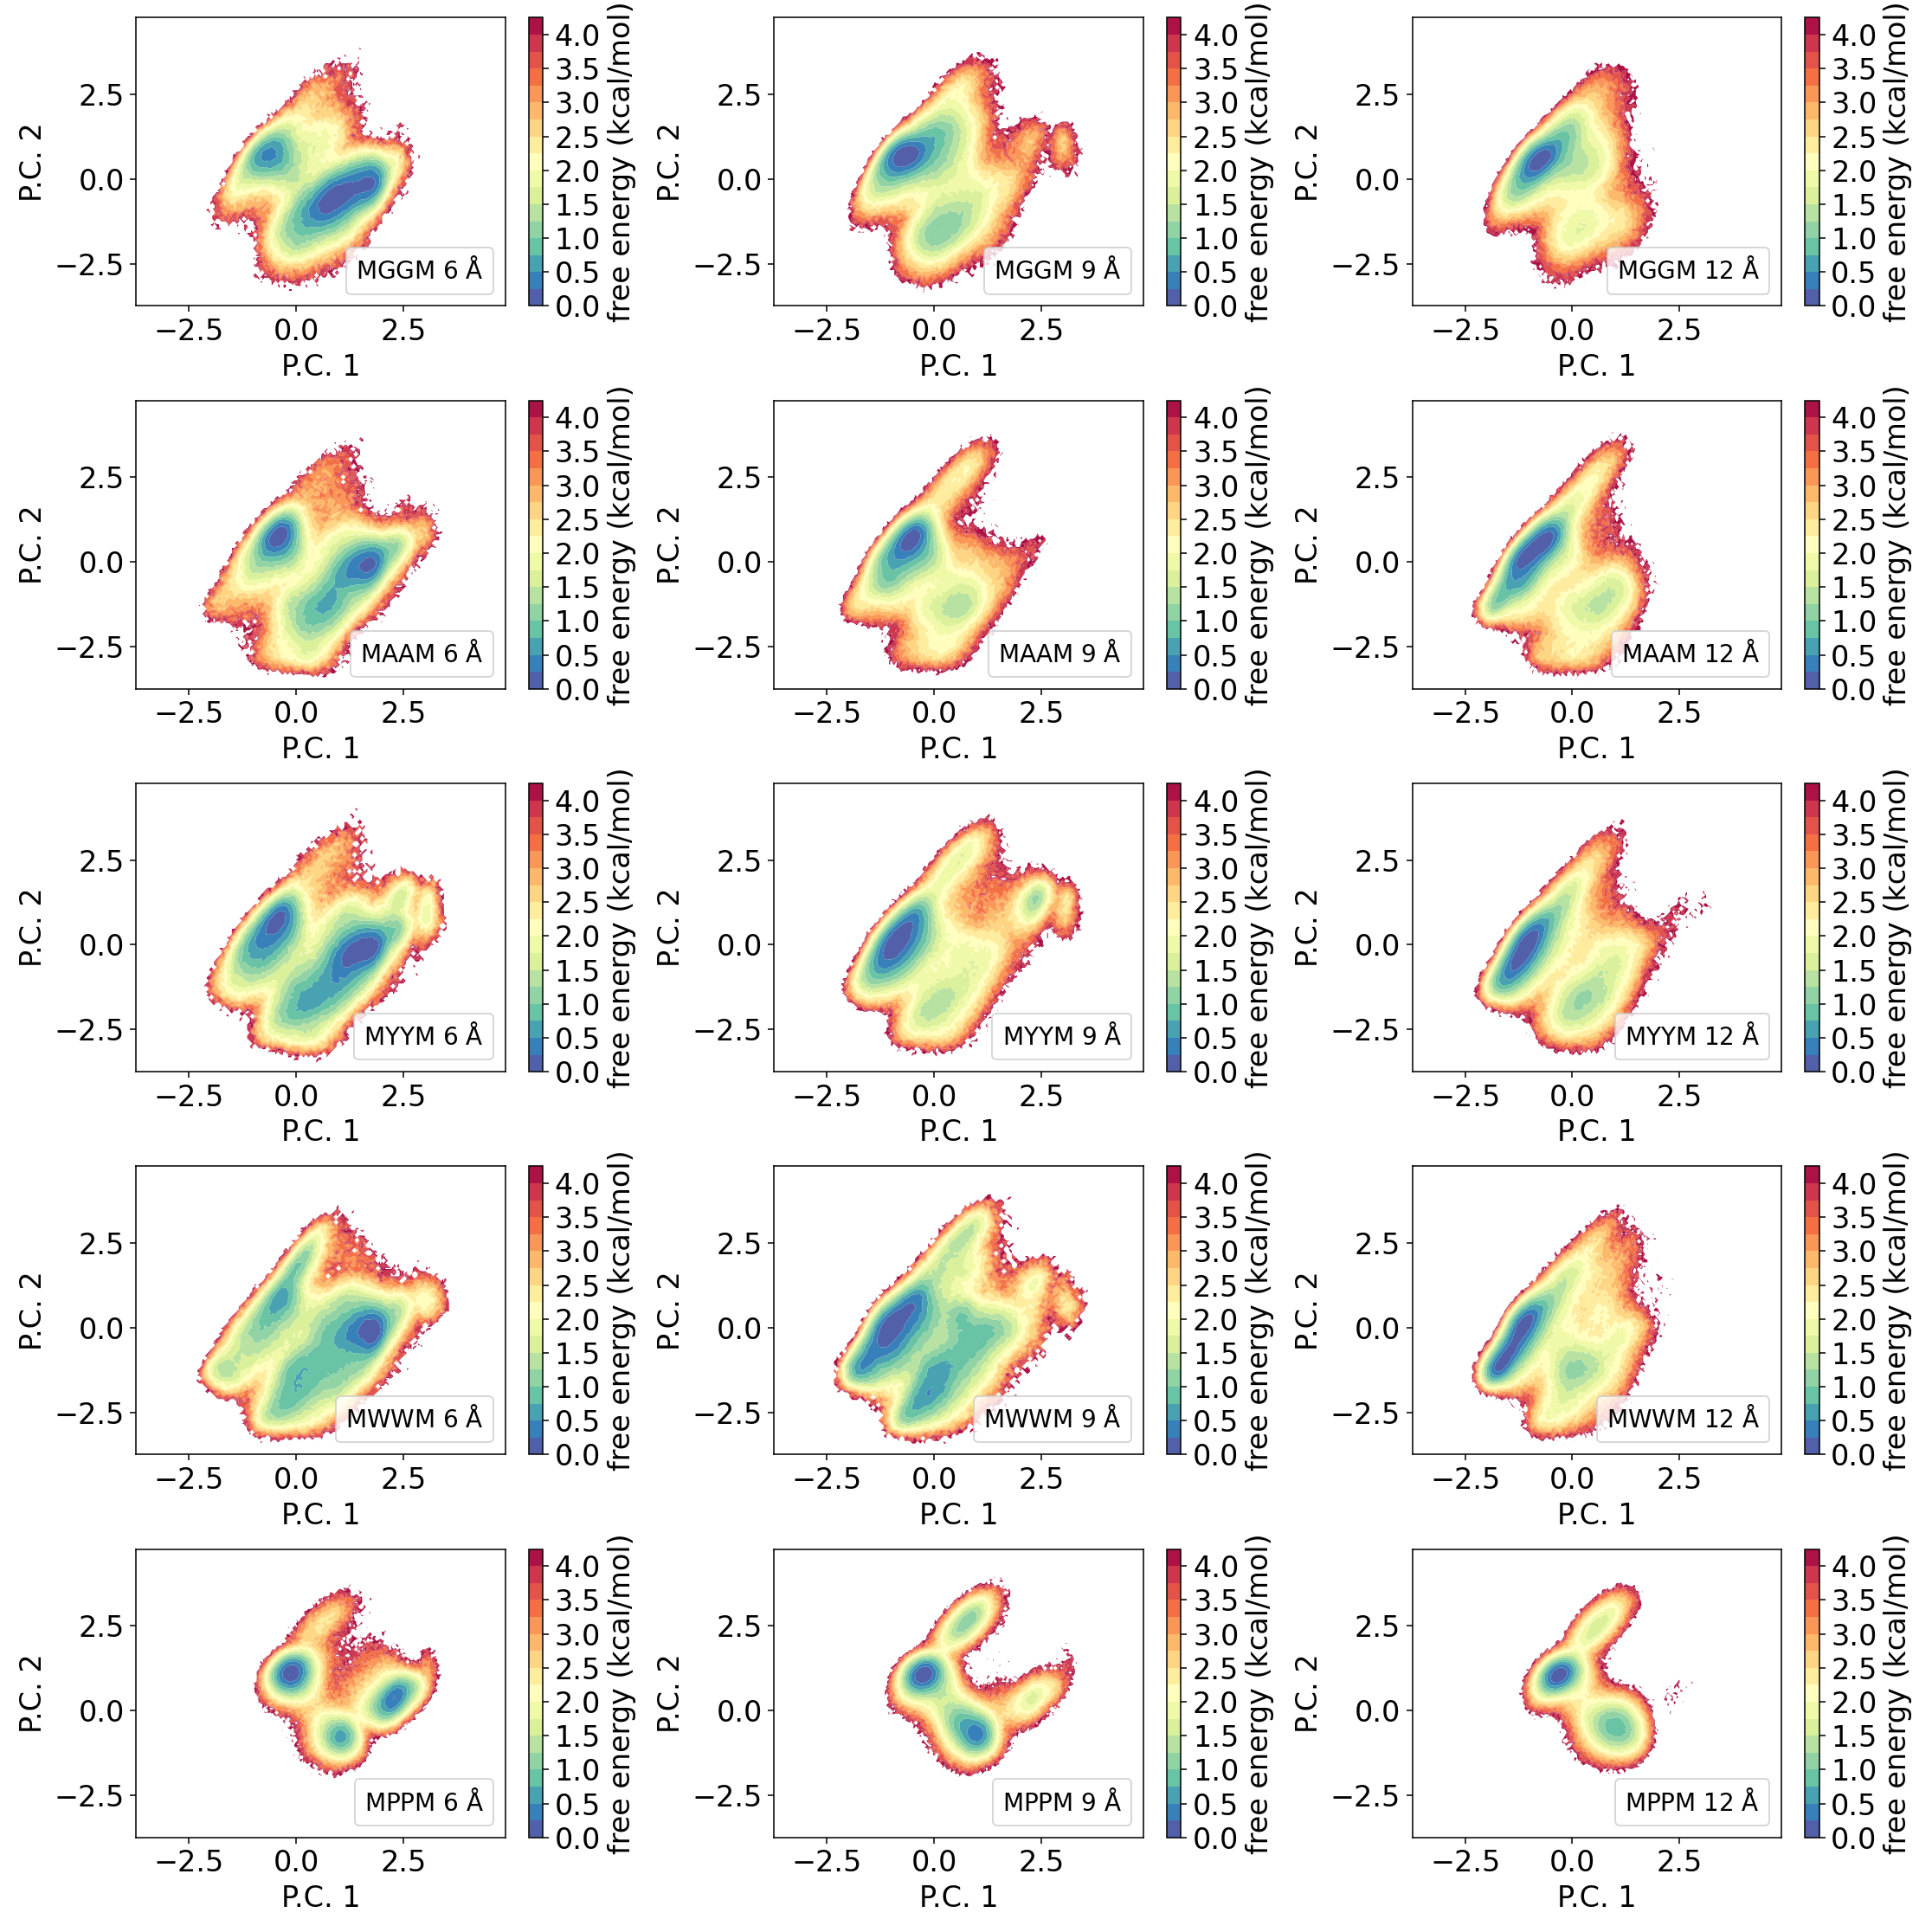

In [97]:
%matplotlib notebook
pylab.rcParams.update({'figure.figsize': (16,16)})
nbins = 100
xlim = [pcs[:,0].min(), pcs[:,0].max()]
ylim = [pcs[:,1].min(), pcs[:,1].max()]
#xticks = [0,2,4,6,8,10,12]
#yticks = [0,45,90,135,180]
xlabel = r'P.C. 1'
ylabel = r'P.C. 2'
holds = [6,9,12]

fig, ax = plt.subplots(len(dirnames), len(systems))
for i in range(len(dirnames)):
    for j in range(len(systems)):
        pyemma.plots.plot_free_energy(pcs[i,j,:,0], pcs[i,j,:,1], 
                                      ax=ax[i,j], nbins=nbins,
                                      #ncontours=10,#vmax=4,
                                      levels=np.arange(0,4.5,.25),
                                      cmap=plt.cm.Spectral_r,antialiased=True,
                                      kT=0.5925, cbar_label='free energy (kcal/mol)')#, avoid_zero_count=True)
        ax[i,j].plot([],[], label=r'%s %i $\mathrm{\AA}$'%(sequences[i],holds[j]))
        ax[i,j].set_xlabel(xlabel)#, labelpad=-10)
        ax[i,j].set_ylabel(ylabel)#, labelpad=-30)
        ax[i,j].set_xlim(xlim)
        ax[i,j].set_ylim(ylim)
        #ax[i,j].set_xticks(xticks)
        #ax[i,j].set_yticks(yticks)    
        ax[i,j].legend(fontsize='x-large',handlelength=0,handletextpad=0,loc='lower right')  
        
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


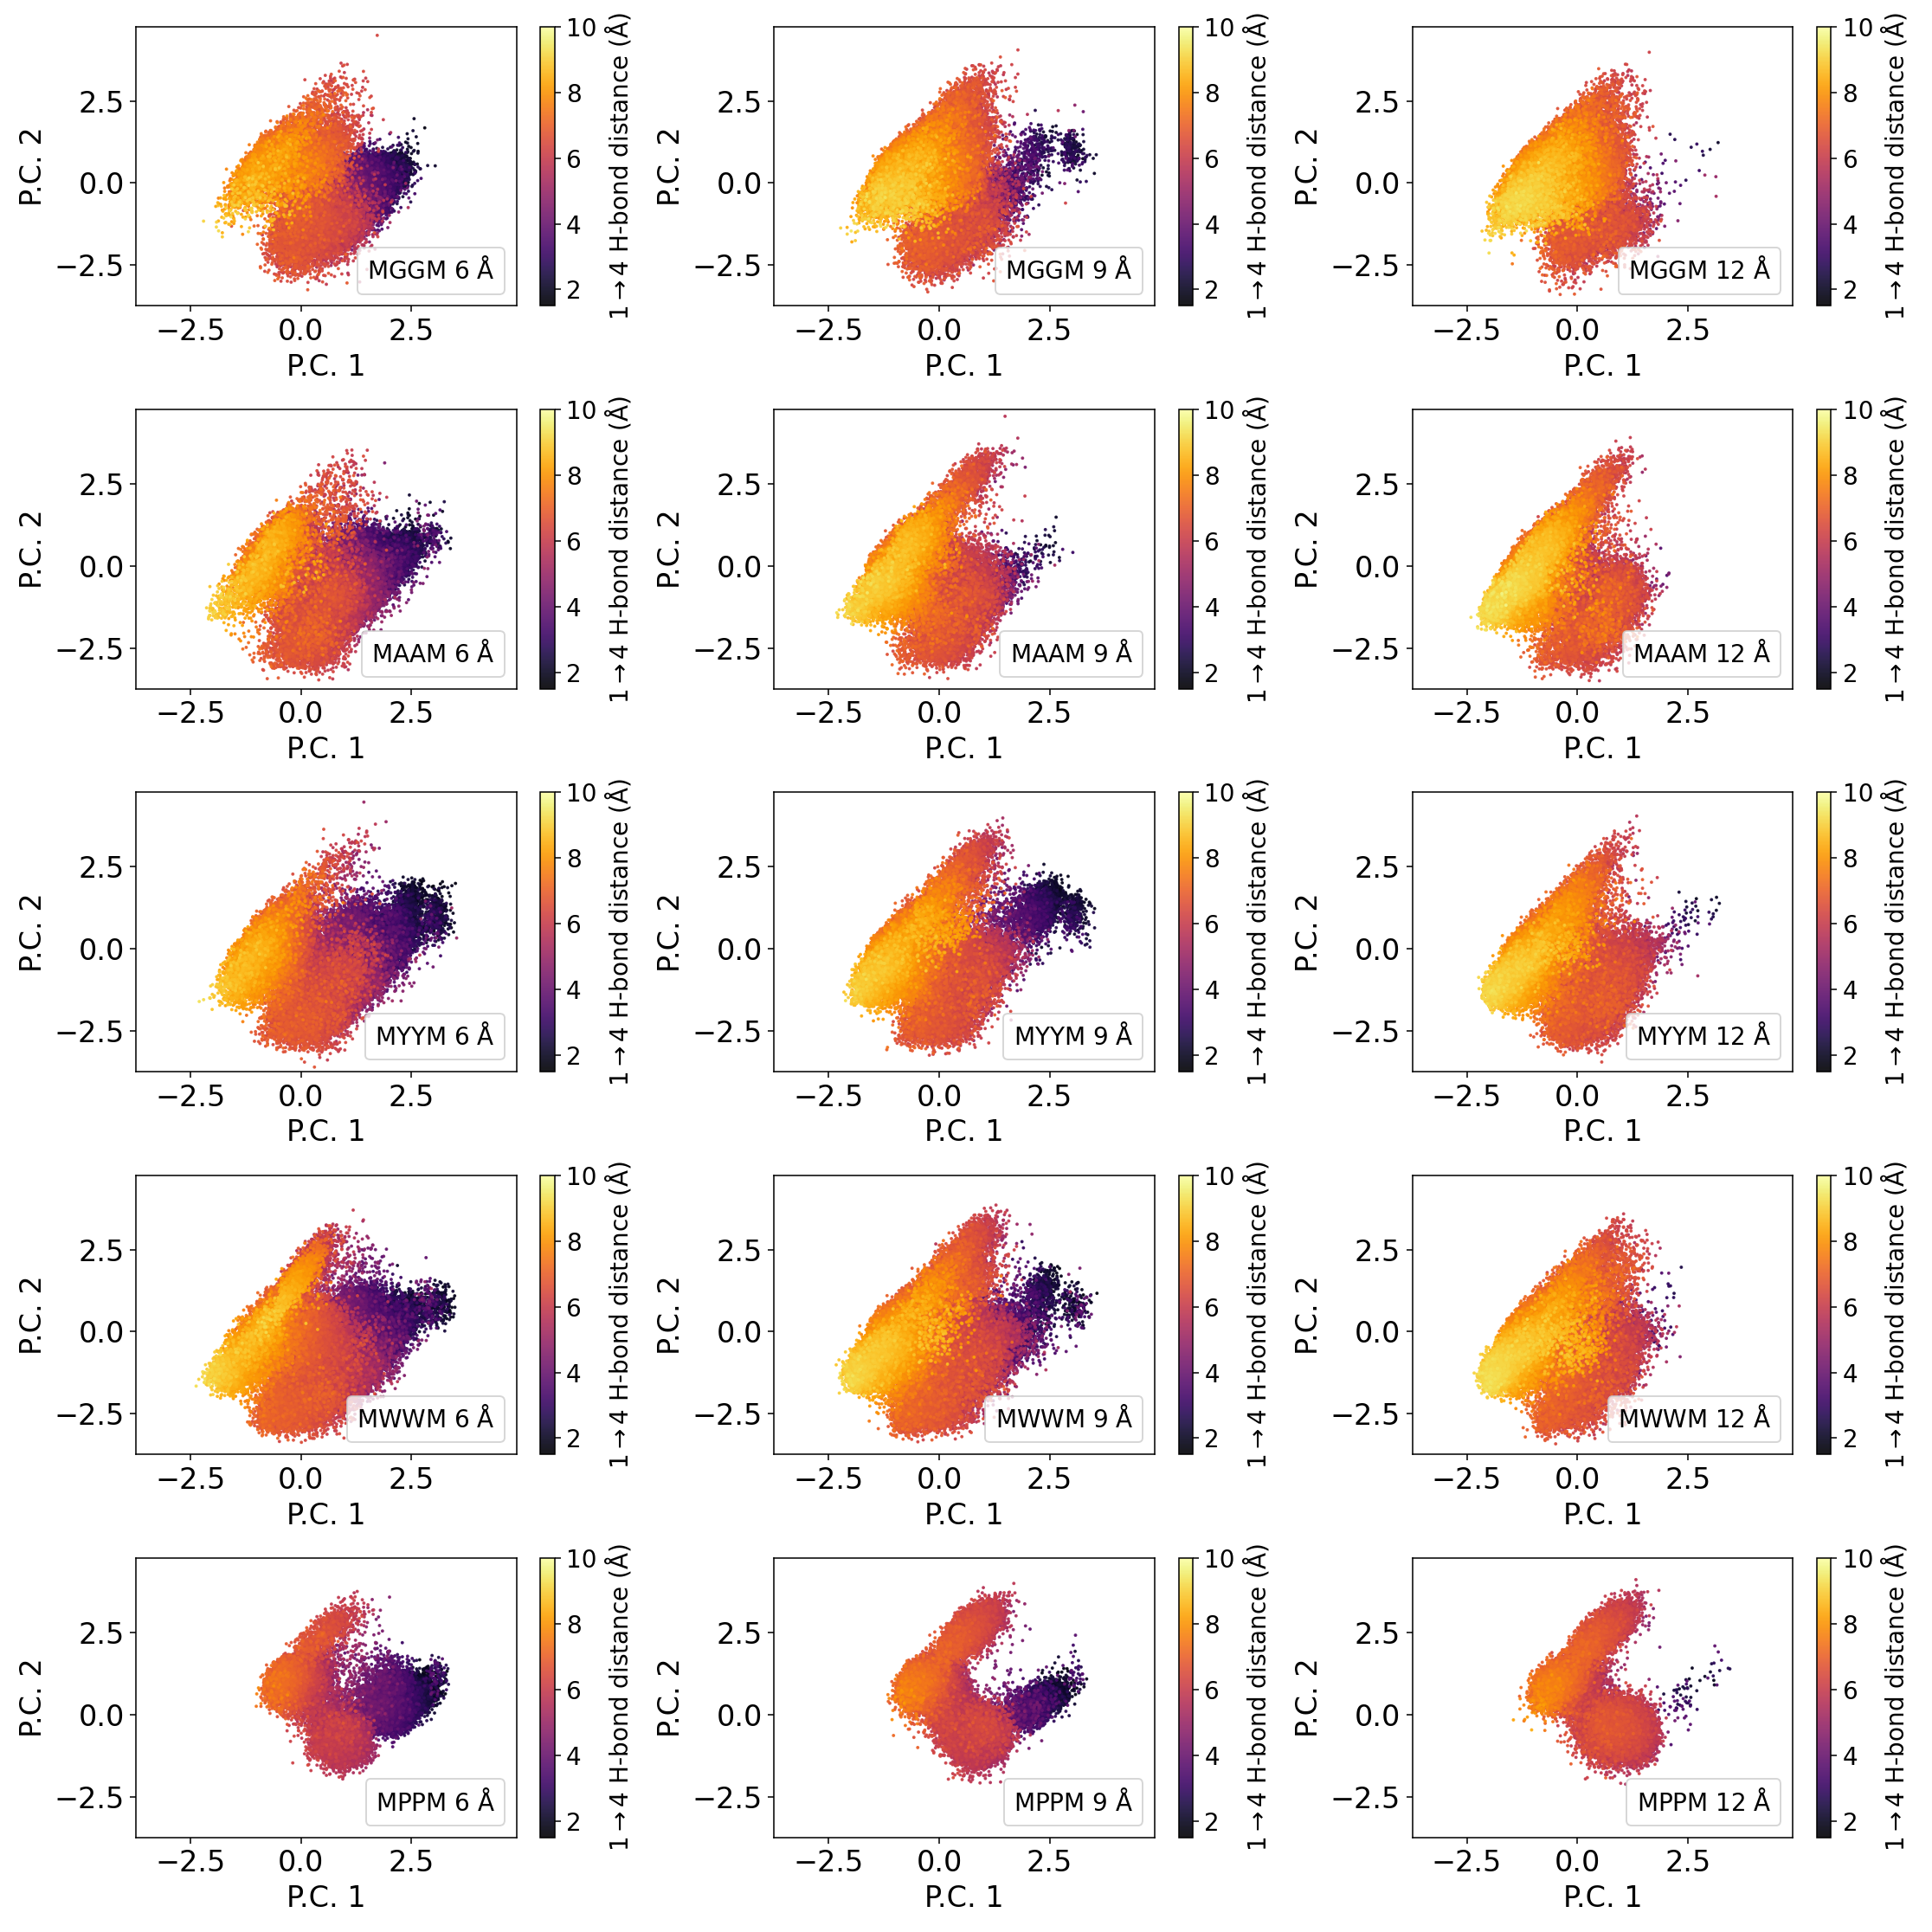

In [98]:
%matplotlib notebook
pylab.rcParams.update({'figure.figsize': (16,16)})
nbins = 100
xlim = [pcs[:,0].min(), pcs[:,0].max()]
ylim = [pcs[:,1].min(), pcs[:,1].max()]
#xticks = [0,2,4,6,8,10,12]
#yticks = [0,45,90,135,180]
xlabel = r'P.C. 1'
ylabel = r'P.C. 2'
holds = [6,9,12]
stride=10

fig, ax = plt.subplots(len(dirnames), len(systems))
for i in range(len(dirnames)):
    for j in range(len(systems)):
        order = hbond_dists[i,j,::stride].flatten().argsort()
        pij=ax[i,j].scatter(pcs[i,j,::stride,0][order], pcs[i,j,::stride,1][order], 
                        c=hbond_dists[i,j,::stride][order], 
                        cmap=plt.cm.inferno, alpha=0.9, s=1, vmin=1.5,vmax=10)
        ax[i,j].plot([],[], label=r'%s %i $\mathrm{\AA}$'%(sequences[i],holds[j]))
        ax[i,j].set_xlabel(xlabel)#, labelpad=-10)
        ax[i,j].set_ylabel(ylabel)#, labelpad=-30)
        ax[i,j].set_xlim(xlim)
        ax[i,j].set_ylim(ylim)
        #ax[i,j].set_xticks(xticks)
        #ax[i,j].set_yticks(yticks)    
        ax[i,j].legend(fontsize='x-large',handlelength=0,handletextpad=0,loc='lower right')  
        cbij = plt.colorbar(pij,ax=ax[i,j])#,ticks=[2,4,6,8,10])
        cbij.set_label(r'1$\rightarrow$4 H-bond distance ($\mathrm{\AA}$)',fontsize='x-large')
        cbij.set_ticks([2,4,6,8,10],fontsize='x-large')
        cbij.set_ticklabels(['2','4','6','8','10'],fontsize='x-large')
        
        
plt.tight_layout()
plt.show()

In [50]:
# save hold6 conformers

winners6turn = []
for i in range(len(dirnames)):
    outfile_turn = '%s/2023-01-20/conformers/4mer/%s-6-turn.xyz'%(home, sequences[i])
    winner_turn = np.argmin(np.abs(hbond_dists[i,0] - hold6_dists[i,0]))
    winners6turn.append(winner_turn)
    trajs[i][0][winner_turn].save_xyz(outfile_turn)
    with open(outfile_turn, 'r') as f:
        lines = f.readlines()
    newlines = []
    newlines.append(lines[0])
    newlines.append(lines[1])
    for j in range(2,len(lines)):
        splits = lines[j].split()
        newlines.append('   '.join([splits[0][0], splits[1], splits[2], splits[3]]) + '\n')
    with open(outfile_turn, 'w') as f:
        for j in range(len(newlines)):
            f.write(newlines[j])

In [52]:
# save hold12 conformers

for i in range(len(dirnames)):
    outfile_ext = '%s/2023-01-20/conformers/%s-12-ext.xyz'%(home, sequences[i]) 
    winner_ext = np.argmin(np.abs(hbond_dists[i,2] - hold12_dists[i]))
    trajs[i][2][winner_ext].save_xyz(outfile_ext)
    with open(outfile_ext, 'r') as f:
        lines = f.readlines()
    newlines = []
    newlines.append(lines[0])
    newlines.append(lines[1])
    for j in range(2, len(lines)):
        splits = lines[j].split()
        newlines.append('   '.join([splits[0][0], splits[1], splits[2], splits[3]]) + '\n')
    with open(outfile_ext, 'w') as f:
        for j in range(len(newlines)):
            f.write(newlines[j])

## 5mer conformer extraction $\downarrow$

In [8]:
home = '/path/to/dir'
dirnames  = ['gly/MGGGM',
             'ala/MAAAM',
             'tyr/MYYYM',
             'trp/MWWWM',
             'pro/MPPPM']
peptides  = [dirname.split('/')[0] for dirname in dirnames] # gly, ala, tyr, trp, pro
sequences = [dirname.split('/')[1] for dirname in dirnames] # MGGM,MAAM,MYYM,MWWM,MPPM
systems   = ['hold-orient-efieldall-6',
             'hold-orient-efieldall-9',
             'hold-orient-efieldall-12']
holds = [6, 9, 12]
n_reps = 16
n_residues = 5
#last_n_frames = 25000 # last 100 ns of each rep
last_n_frames = 47500 # last 190 ns of each rep
rad_to_deg = 180. / np.pi
traj_files = [[['%s/%s/%s/strip_%i.dcd'%(home,dirname,system,rep) 
                for rep in range(n_reps)] 
               for system in systems] 
              for dirname in dirnames]
top_files = ['%s/%s/build/strip.psf'%(home,dirname) 
             for dirname in dirnames]

In [9]:
trajs = []
for i,dirname in enumerate(dirnames):
    traji = []
    for j,system in enumerate(systems):
        trajij = []
        for rep in range(n_reps):
            trajij.append(md.load(traj_files[i][j][rep], top=top_files[i])[-last_n_frames:])
        traji.append(md.join(trajij))
    trajs.append(traji)

In [10]:
for trajgroup in trajs:
    assert trajgroup[0].n_frames == trajgroup[1].n_frames == trajgroup[2].n_frames 
n_frames = trajs[0][0].n_frames

In [11]:
# i -> i+3 H-bond distance (2->5)

hbond_dist_sel = ['resid 1 and name O',
                  'resid 4 and name H']

hbond_dist_inds = [[[trajs[i][j].top.select(sel)[0] 
                     for sel in hbond_dist_sel] 
                    for j in range(len(systems))] 
                   for i in range(len(dirnames))]

hbond_dists = 10. * np.array([[np.sqrt(np.sum(np.square(trajs[i][j].xyz[:,hbond_dist_inds[i][j][0]] - trajs[i][j].xyz[:,hbond_dist_inds[i][j][1]]),axis=1)) 
                               for j in range(len(systems))] 
                              for i in range(len(dirnames))])

<IPython.core.display.Javascript object>


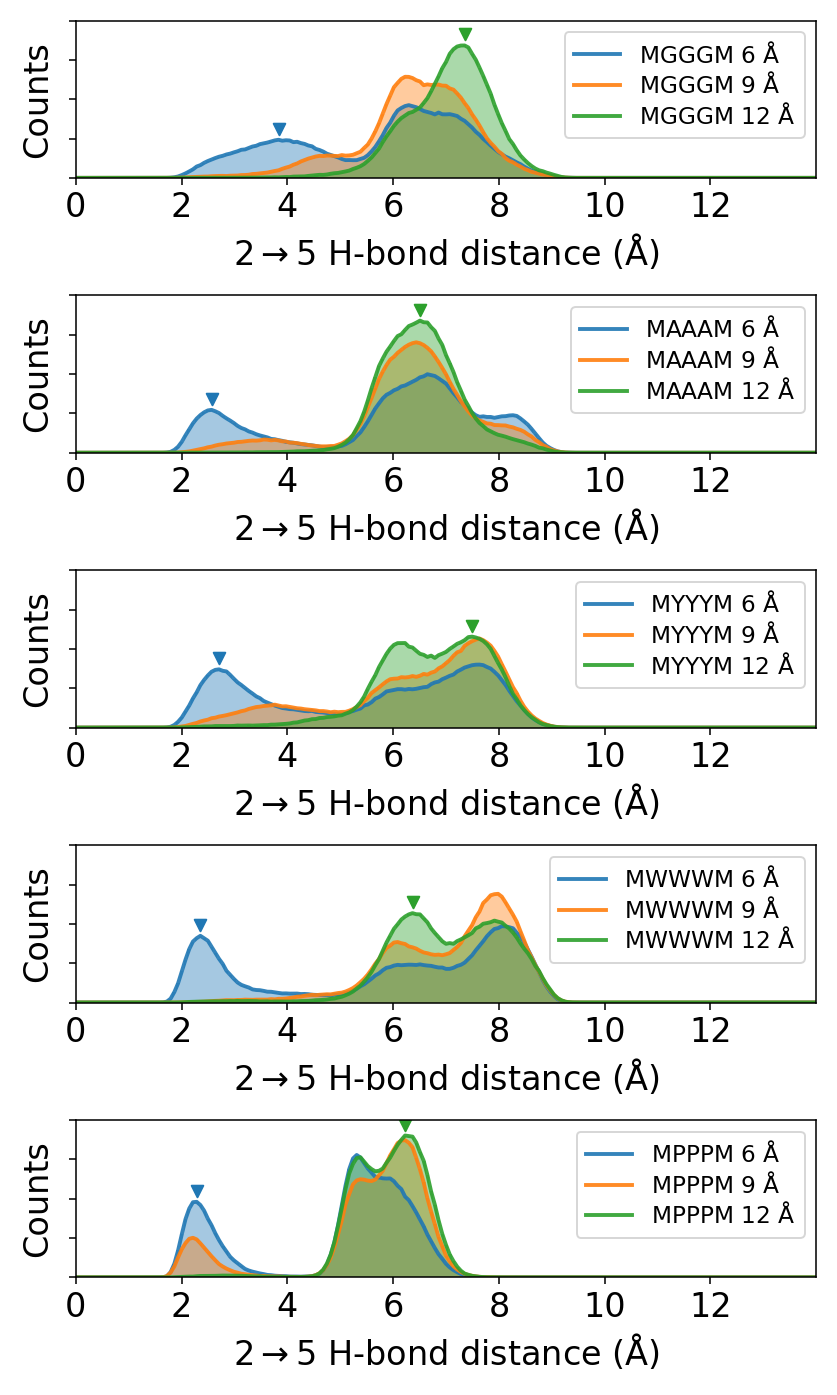

In [30]:
%matplotlib notebook
pylab.rcParams.update({'figure.figsize': (6,10)})
nbins=200
xlim=[0,14]
binc= 0.5 * (np.linspace(xlim[0],xlim[1],nbins)[1:] + np.linspace(xlim[0],xlim[1],nbins)[:-1])
xlabel=r'2$\rightarrow$5 H-bond distance ($\mathrm{\AA}$)'
labels = [r' %i $\mathrm{\AA}$'%(hold) for hold in (6,9,12)]
xticks=[0,2,4,6,8,10,12]

maxy_ij = 0
fig, ax = plt.subplots(len(dirnames))
for i in range(len(dirnames)):
    for j in range(len(systems)):
        # plot hist and save bin heights
        binh,_,_ = ax[i].hist(hbond_dists[i,j], alpha=0.4, color='C%i'%j,
                              bins=np.linspace(xlim[0],xlim[1],nbins))
        maxy_ij = np.array([maxy_ij, binh.max()]).max()
        # plot bin heights as line
        ax[i].plot(binc, binh, color='C%i'%j, alpha=0.9, linewidth=2,
                   label=sequences[i]+labels[j])
        ax[i].legend(fontsize='large', labelspacing=0.2)
        # find peaks and plot as X
        if j != 1:
            peakids = find_peaks(binh, distance=20, prominence=3000)[0]
            ax[i].scatter(binc[peakids[0]],binh[peakids[0]]+2500,c='C%i'%j,marker='v')
    ax[i].set_xlabel(xlabel)
    ax[i].set_xlim(xlim)
    ax[i].set_xticks(xticks)
    
for i in range(len(dirnames)):
    ax[i].set_ylabel('Counts')
    ax[i].set_ylim(0,maxy_ij+3500)
    ax[i].set_yticks(np.linspace(0,maxy_ij+3500,5))
    ax[i].set_yticklabels([])
plt.tight_layout()
plt.show()

In [100]:
# save hold6 conformers

winners6turn = []
for i in range(len(dirnames)):
    outfile_turn = '%s/2023-01-20/conformers/5mer/%s-6-turn.xyz'%(home, sequences[i])
    winner_turn = np.argmin(np.abs(hbond_dists[i,0] - hold6_dists[i,0]))
    winners6turn.append(winner_turn)
    trajs[i][0][winner_turn].save_xyz(outfile_turn)
    with open(outfile_turn, 'r') as f:
        lines = f.readlines()
    newlines = []
    newlines.append(lines[0])
    newlines.append(lines[1])
    for j in range(2,len(lines)):
        splits = lines[j].split()
        newlines.append('   '.join([splits[0][0], splits[1], splits[2], splits[3]]) + '\n')
    with open(outfile_turn, 'w') as f:
        for j in range(len(newlines)):
            f.write(newlines[j])

In [101]:
# save hold12 conformers
winners12 = []
for i in range(len(dirnames)):
    outfile_ext = '%s/2023-01-20/conformers/5mer/%s-12-ext.xyz'%(home, sequences[i]) 
    winner_ext = np.argmin(np.abs(hbond_dists[i,2] - hold12_dists[i]))
    winners12.append(winner_ext)
    trajs[i][2][winner_ext].save_xyz(outfile_ext)
    with open(outfile_ext, 'r') as f:
        lines = f.readlines()
    newlines = []
    newlines.append(lines[0])
    newlines.append(lines[1])
    for j in range(2, len(lines)):
        splits = lines[j].split()
        newlines.append('   '.join([splits[0][0], splits[1], splits[2], splits[3]]) + '\n')
    with open(outfile_ext, 'w') as f:
        for j in range(len(newlines)):
            f.write(newlines[j])

In [73]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [108]:
n_residues=5

In [109]:
bb_sel = 'backbone or name OXT'
bb_inds = [trajs[i][0].top.select(bb_sel) 
           for i in range(len(dirnames))]
n_bb = len(bb_inds[0])
n_unique = (n_bb*(n_bb-1))//2
print('%i shared backbone atoms, %i unique pairwise distances'%(n_bb, n_unique))

21 shared backbone atoms, 210 unique pairwise distances


In [110]:
# verify ordering of backbone atoms
for i in range(len(dirnames)):
    bb_atom_names = [atom.name for atom in trajs[i][0].atom_slice(bb_inds[i]).top.atoms]
    print(bb_atom_names)

['N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'OXT']
['N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'OXT']
['N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'OXT']
['N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'OXT']
['N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'N', 'CA', 'C', 'O', 'OXT']


In [111]:
n_residues

5

In [112]:
for i in range(n_bb):
    bb_per_res = (n_bb - 1)/n_residues
    res_id = int(i/bb_per_res) if i != n_bb - 1 else n_residues-1
    bb_atom_names[i] += str(res_id+1)
bb_atom_names

['N1',
 'CA1',
 'C1',
 'O1',
 'N2',
 'CA2',
 'C2',
 'O2',
 'N3',
 'CA3',
 'C3',
 'O3',
 'N4',
 'CA4',
 'C4',
 'O4',
 'N5',
 'CA5',
 'C5',
 'O5',
 'OXT5']

In [113]:
# assign pair labels
bb_pair_i, bb_pair_j = unravel_upper_triangle_index(n_bb)
bb_pair_labels = []
for i in range(n_unique):
    bb_pair_labels.append('%s-%s'%(bb_atom_names[bb_pair_i[i]], bb_atom_names[bb_pair_j[i]]))
bb_pair_labels

['N1-CA1',
 'N1-C1',
 'N1-O1',
 'N1-N2',
 'N1-CA2',
 'N1-C2',
 'N1-O2',
 'N1-N3',
 'N1-CA3',
 'N1-C3',
 'N1-O3',
 'N1-N4',
 'N1-CA4',
 'N1-C4',
 'N1-O4',
 'N1-N5',
 'N1-CA5',
 'N1-C5',
 'N1-O5',
 'N1-OXT5',
 'CA1-C1',
 'CA1-O1',
 'CA1-N2',
 'CA1-CA2',
 'CA1-C2',
 'CA1-O2',
 'CA1-N3',
 'CA1-CA3',
 'CA1-C3',
 'CA1-O3',
 'CA1-N4',
 'CA1-CA4',
 'CA1-C4',
 'CA1-O4',
 'CA1-N5',
 'CA1-CA5',
 'CA1-C5',
 'CA1-O5',
 'CA1-OXT5',
 'C1-O1',
 'C1-N2',
 'C1-CA2',
 'C1-C2',
 'C1-O2',
 'C1-N3',
 'C1-CA3',
 'C1-C3',
 'C1-O3',
 'C1-N4',
 'C1-CA4',
 'C1-C4',
 'C1-O4',
 'C1-N5',
 'C1-CA5',
 'C1-C5',
 'C1-O5',
 'C1-OXT5',
 'O1-N2',
 'O1-CA2',
 'O1-C2',
 'O1-O2',
 'O1-N3',
 'O1-CA3',
 'O1-C3',
 'O1-O3',
 'O1-N4',
 'O1-CA4',
 'O1-C4',
 'O1-O4',
 'O1-N5',
 'O1-CA5',
 'O1-C5',
 'O1-O5',
 'O1-OXT5',
 'N2-CA2',
 'N2-C2',
 'N2-O2',
 'N2-N3',
 'N2-CA3',
 'N2-C3',
 'N2-O3',
 'N2-N4',
 'N2-CA4',
 'N2-C4',
 'N2-O4',
 'N2-N5',
 'N2-CA5',
 'N2-C5',
 'N2-O5',
 'N2-OXT5',
 'CA2-C2',
 'CA2-O2',
 'CA2-N3',
 'CA2-CA3',
 'CA2

In [83]:
# calculate E.D.M for each system using only shared backbone atoms
start = time.time()
bb_distmats = np.zeros((len(dirnames), len(systems), n_frames, n_unique))
for i in range(len(dirnames)):
    for j in range(len(systems)):
        bb_distmats[i,j] = p_sym_dist_mats(trajs[i][j].xyz[:,bb_inds[i]])
end = time.time()
bb_distmats *= 10.
print('%.2f seconds runtime for %.2E distances (%.2E seconds per distance)'%((end-start), len(bb_distmats.ravel()), (end-start)/len(bb_distmats.ravel())))

28.58 seconds runtime for 2.39E+09 distances (1.19E-08 seconds per distance)


In [84]:
# reshape and scale training data
scaler = StandardScaler()
X_train = bb_distmats.reshape(np.product(bb_distmats.shape[:-1]),-1)
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)

In [85]:
pca_model = PCA(n_components=5,
                whiten=True)
#X_train = bb_distmats.reshape(np.product(bb_distmats.shape[:-1]),-1)
pca_model.fit(X_train_scale)

PCA(n_components=5, whiten=True)

In [86]:
pcs = np.zeros((len(dirnames), len(systems), n_frames, 5))
for i in range(len(dirnames)):
    for j in range(len(systems)):
        pcs[i,j] = pca_model.transform(scaler.transform(bb_distmats[i,j]))

In [87]:
pca_model.explained_variance_ratio_

array([0.27704459, 0.11160939, 0.06278129, 0.04441654, 0.03613483])

In [120]:
bb_pair_labels

['N1-CA1',
 'N1-C1',
 'N1-O1',
 'N1-N2',
 'N1-CA2',
 'N1-C2',
 'N1-O2',
 'N1-N3',
 'N1-CA3',
 'N1-C3',
 'N1-O3',
 'N1-N4',
 'N1-CA4',
 'N1-C4',
 'N1-O4',
 'N1-N5',
 'N1-CA5',
 'N1-C5',
 'N1-O5',
 'N1-OXT5',
 'CA1-C1',
 'CA1-O1',
 'CA1-N2',
 'CA1-CA2',
 'CA1-C2',
 'CA1-O2',
 'CA1-N3',
 'CA1-CA3',
 'CA1-C3',
 'CA1-O3',
 'CA1-N4',
 'CA1-CA4',
 'CA1-C4',
 'CA1-O4',
 'CA1-N5',
 'CA1-CA5',
 'CA1-C5',
 'CA1-O5',
 'CA1-OXT5',
 'C1-O1',
 'C1-N2',
 'C1-CA2',
 'C1-C2',
 'C1-O2',
 'C1-N3',
 'C1-CA3',
 'C1-C3',
 'C1-O3',
 'C1-N4',
 'C1-CA4',
 'C1-C4',
 'C1-O4',
 'C1-N5',
 'C1-CA5',
 'C1-C5',
 'C1-O5',
 'C1-OXT5',
 'O1-N2',
 'O1-CA2',
 'O1-C2',
 'O1-O2',
 'O1-N3',
 'O1-CA3',
 'O1-C3',
 'O1-O3',
 'O1-N4',
 'O1-CA4',
 'O1-C4',
 'O1-O4',
 'O1-N5',
 'O1-CA5',
 'O1-C5',
 'O1-O5',
 'O1-OXT5',
 'N2-CA2',
 'N2-C2',
 'N2-O2',
 'N2-N3',
 'N2-CA3',
 'N2-C3',
 'N2-O3',
 'N2-N4',
 'N2-CA4',
 'N2-C4',
 'N2-O4',
 'N2-N5',
 'N2-CA5',
 'N2-C5',
 'N2-O5',
 'N2-OXT5',
 'CA2-C2',
 'CA2-O2',
 'CA2-N3',
 'CA2-CA3',
 'CA2

In [122]:
np.array(bb_pair_labels)[np.abs(pca_model.components_[0]).argsort()][::-1]

array(['C1-C5', 'C1-N5', 'C1-CA5', 'CA1-C5', 'N2-N5', 'N2-C5', 'CA1-N5',
       'O1-C5', 'CA1-CA5', 'N1-C5', 'C1-O5', 'N2-CA5', 'C1-OXT5',
       'CA1-O5', 'N1-N5', 'CA1-OXT5', 'N1-CA5', 'O1-CA5', 'O1-N5',
       'N1-O5', 'N1-OXT5', 'C2-C5', 'O1-O5', 'O1-OXT5', 'CA2-C5', 'N2-O5',
       'N2-OXT5', 'C2-N5', 'N2-C4', 'C2-CA5', 'O2-C5', 'C1-C4', 'O2-N5',
       'CA2-N5', 'O2-CA5', 'CA2-CA5', 'CA1-C4', 'O2-O5', 'O2-OXT5',
       'C2-C4', 'C2-O5', 'CA2-O5', 'C2-OXT5', 'CA2-OXT5', 'N1-C4',
       'CA2-C4', 'O2-C4', 'O1-C4', 'N3-C5', 'N3-CA5', 'N3-N5', 'C1-N4',
       'C1-CA4', 'N1-N4', 'CA1-N4', 'N3-O5', 'N3-OXT5', 'N2-CA4', 'N2-N4',
       'N1-CA4', 'CA1-CA4', 'O1-N4', 'N1-O4', 'O1-CA4', 'CA1-O4', 'C3-C5',
       'C2-CA4', 'CA3-C5', 'C2-N4', 'C1-O4', 'N3-C4', 'CA3-N5', 'C3-N5',
       'CA3-CA5', 'C3-CA5', 'N2-O4', 'O1-O4', 'N4-O4', 'CA2-CA4', 'O2-N4',
       'CA2-N4', 'O2-CA4', 'N1-C3', 'N3-O3', 'C1-C3', 'O3-C5', 'CA3-O5',
       'N4-N5', 'N4-C5', 'CA3-OXT5', 'C3-O5', 'C3-OXT5', 'CA1-C3',
 

<IPython.core.display.Javascript object>


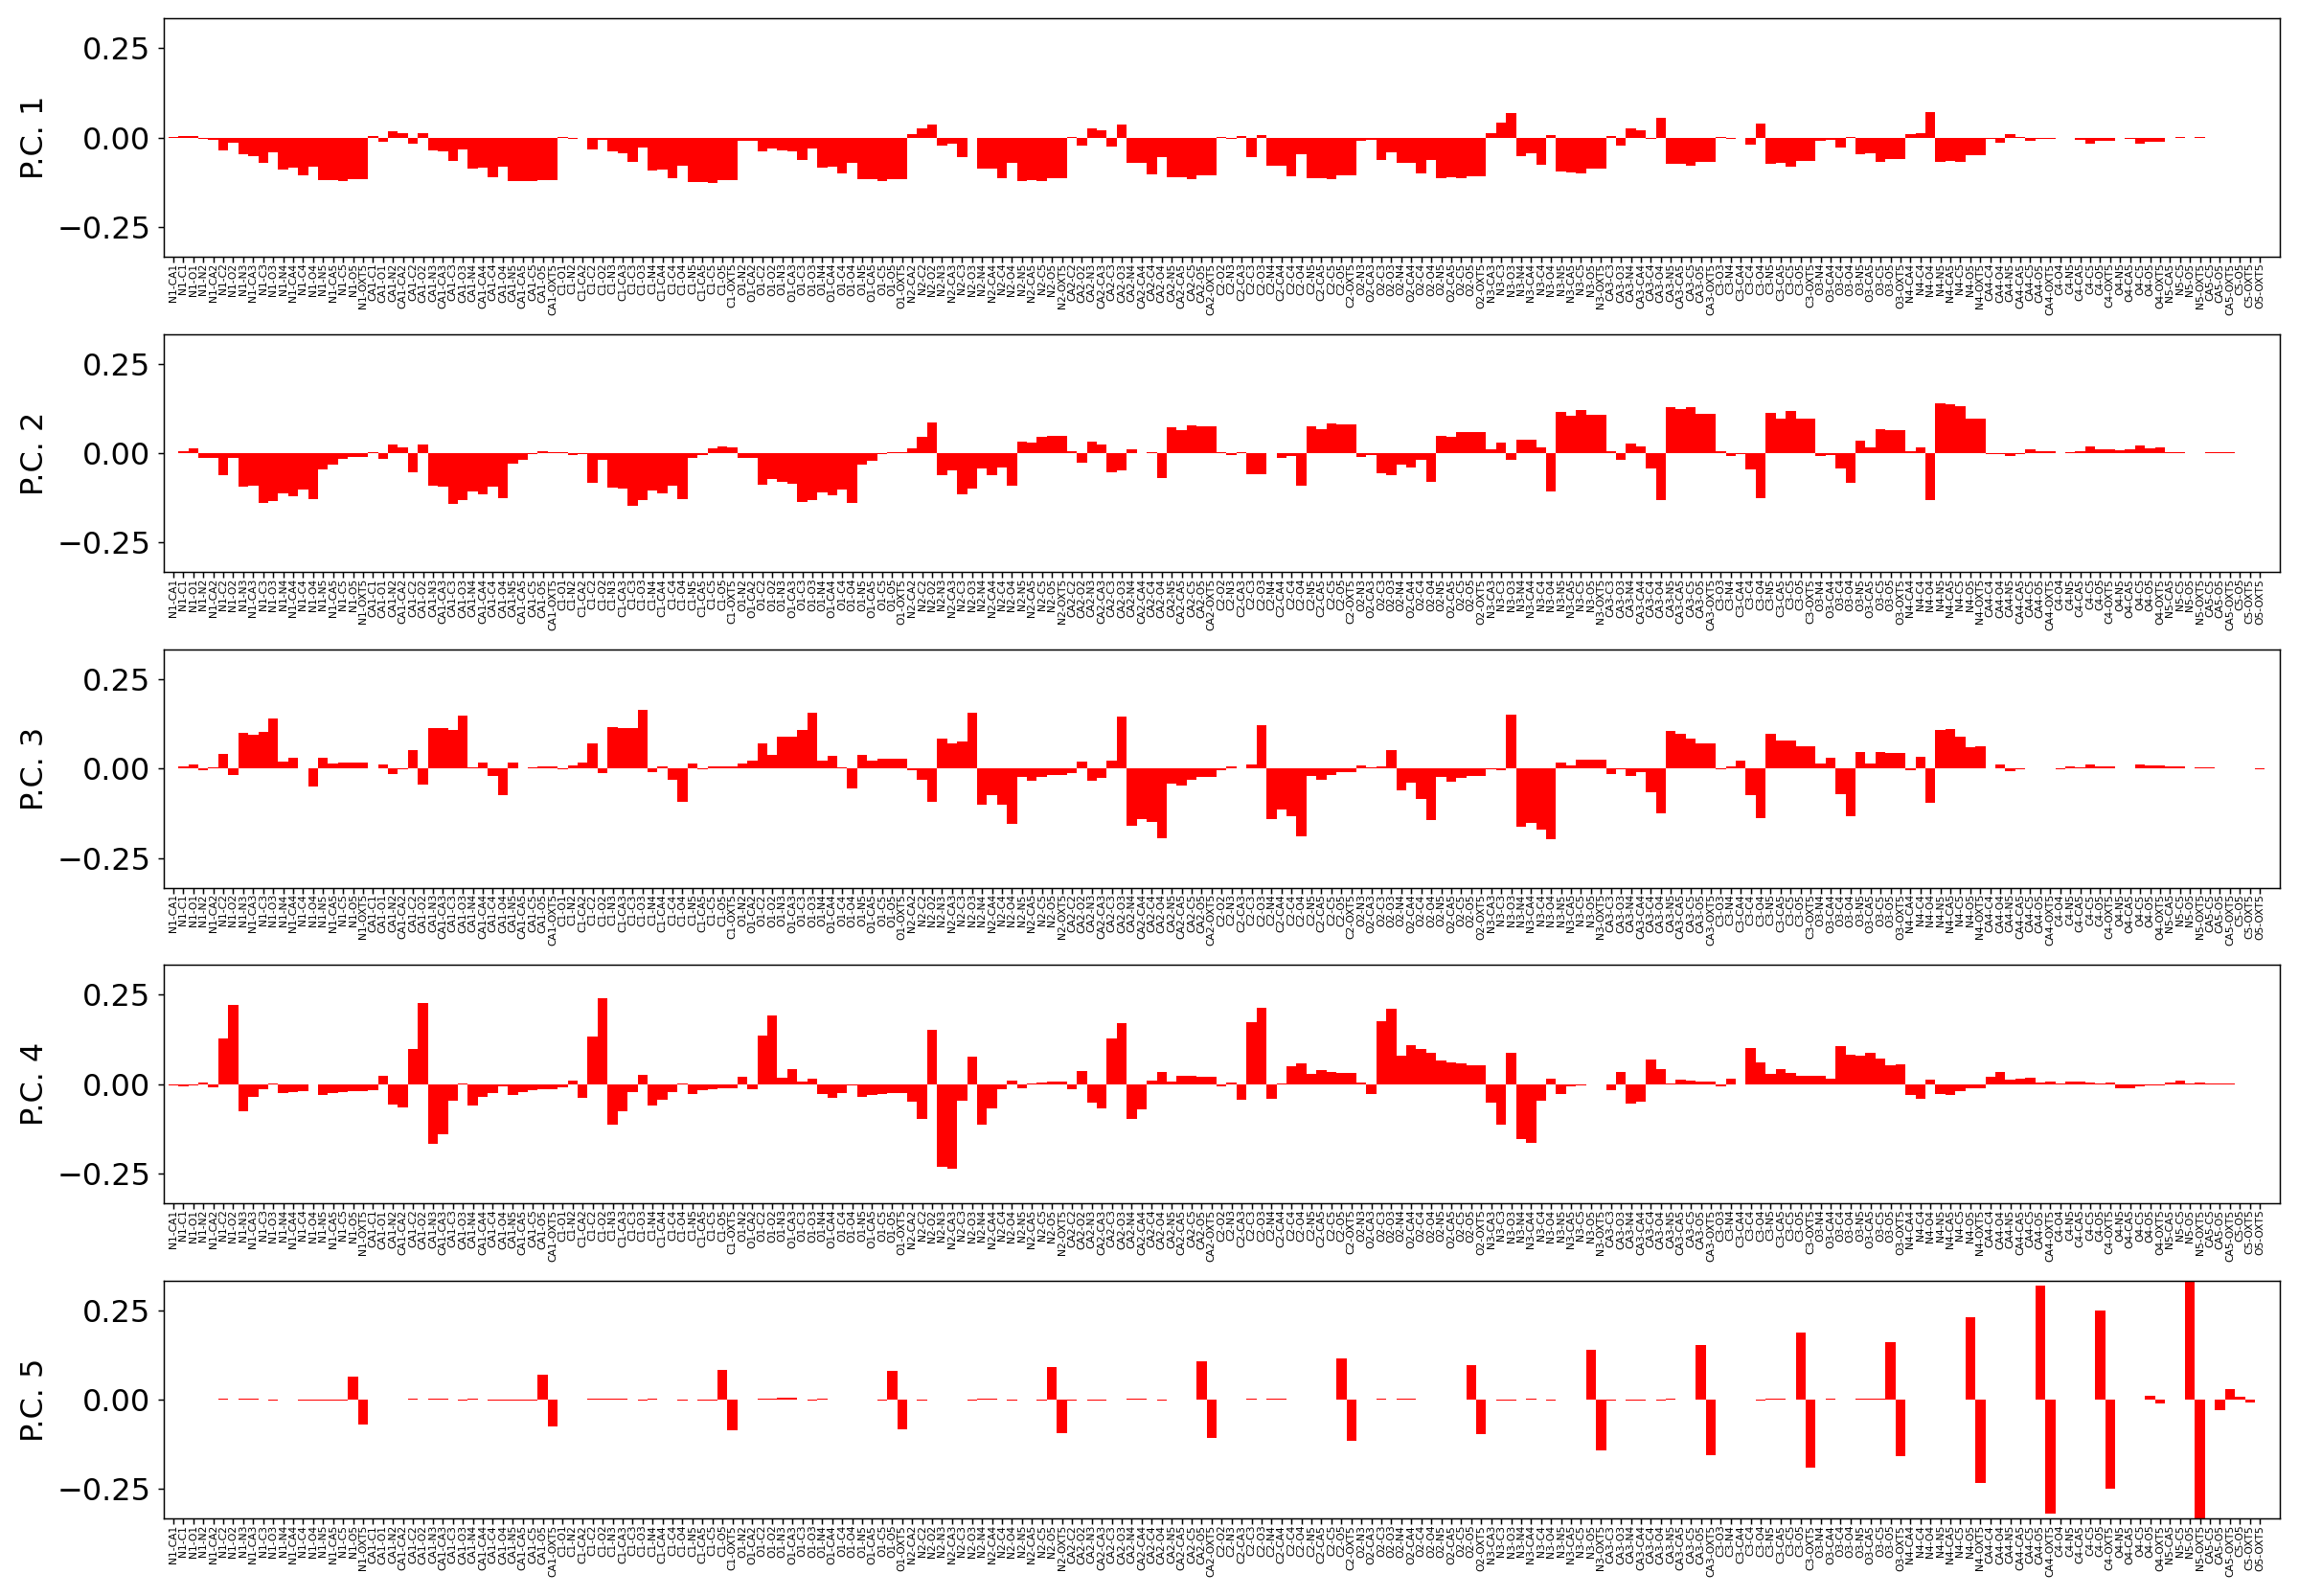

In [114]:
%matplotlib notebook
pylab.rcParams.update({'figure.figsize': (18,pca_model.n_components_*2.5)})
n_comp = pca_model.components_.shape[0]
ylim = pca_model.components_.min(), pca_model.components_.max()
fig, ax = plt.subplots(n_comp)
for i in range(n_comp):
    ax[i].bar(np.arange(n_unique), pca_model.components_[i], 1, tick_label=bb_pair_labels, color='red')
    ax[i].set_xlim(-1,n_unique+1)
    #for j in range(n_unique):
    #    ax[i].bar(j, pca_model.components_[i,j], 1, color='red', tick_label=bb_pair_labels[j])
    #    #ax[i].set_xlim(-1,n_unique+1)
    ax[i].set_ylim(ylim)
    ax[i].set_ylabel('P.C. %i'%(i+1))
for i in range(n_comp):
    for label in ax[i].get_xticklabels():
        label.set_rotation(90)
        label.set_ha('center')
        label.set_fontsize('xx-small')
    for tick in ax[i].get_xaxis().get_major_ticks():
        tick.set_pad(0)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


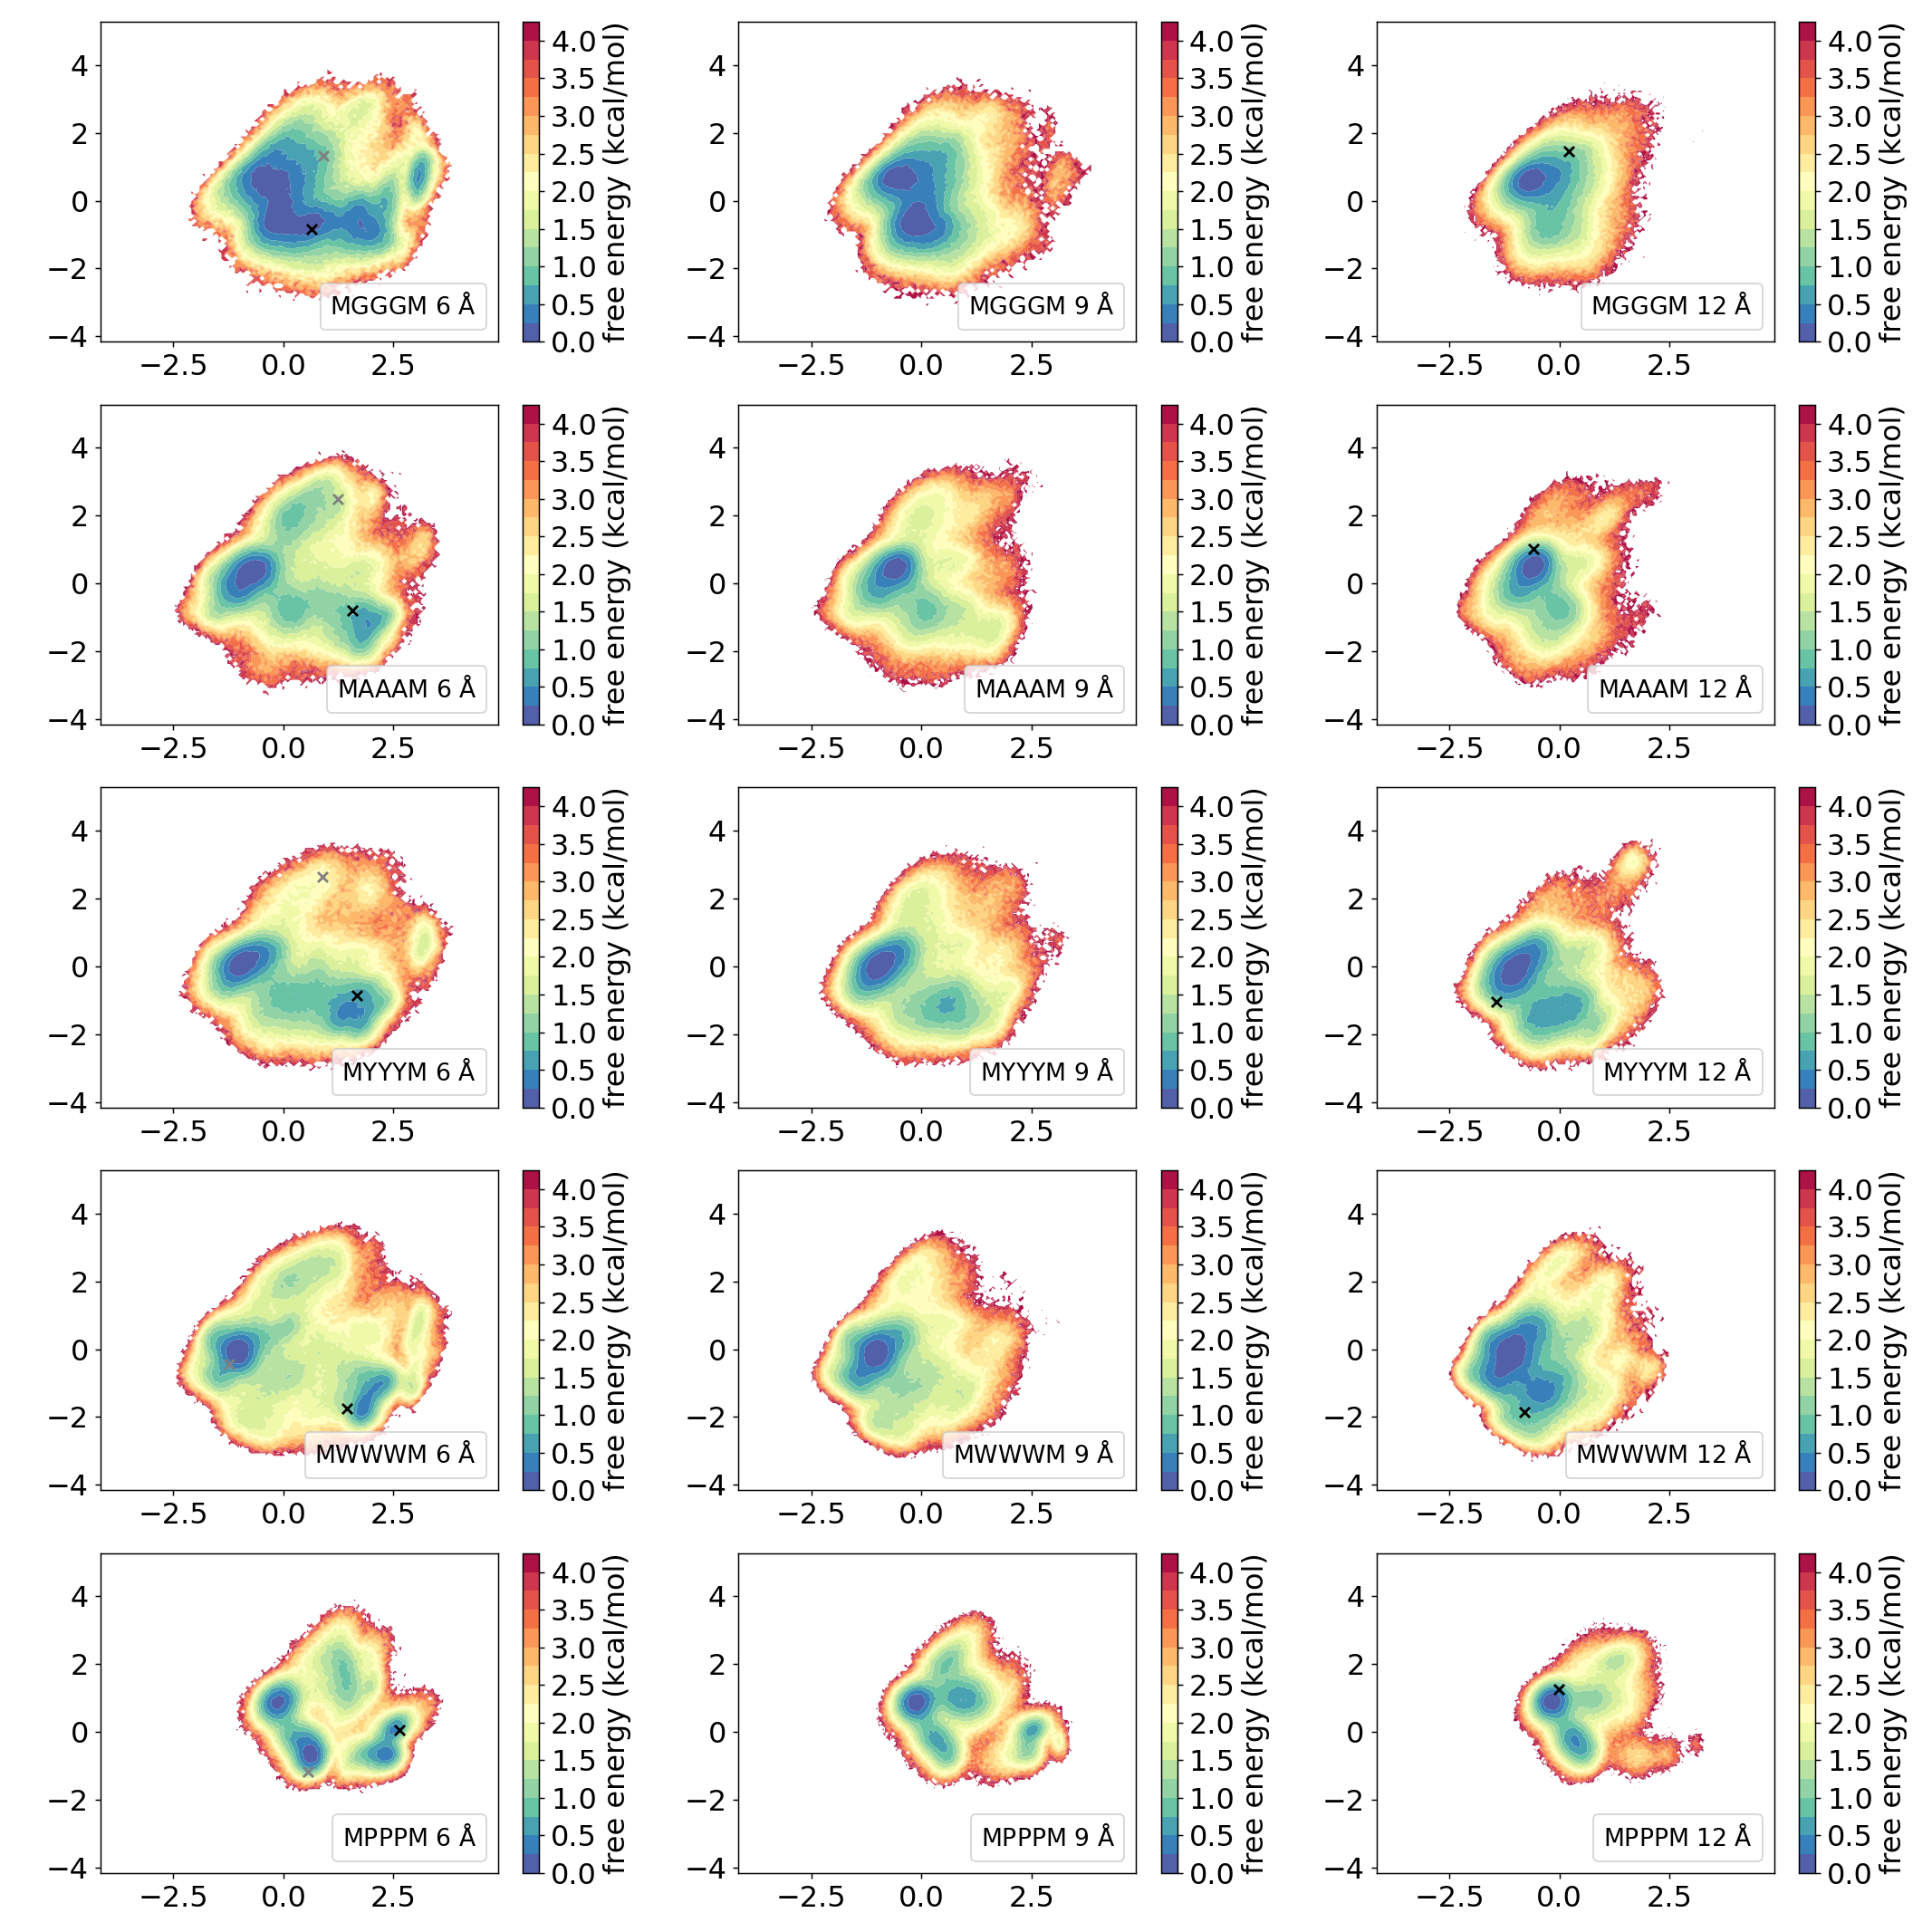

In [105]:
%matplotlib notebook
pylab.rcParams.update({'figure.figsize': (16,16)})
nbins = 100
xlim = [pcs[:,0].min(), pcs[:,0].max()]
ylim = [pcs[:,1].min(), pcs[:,1].max()]
xlabel = r'P.C. 1'
ylabel = r'P.C. 2'
holds = [6,9,12]

fig, ax = plt.subplots(len(dirnames), len(systems))
for i in range(len(dirnames)):
    for j in range(len(systems)):
        pyemma.plots.plot_free_energy(pcs[i,j,:,0], pcs[i,j,:,1], 
                                      ax=ax[i,j], nbins=nbins,
                                      #ncontours=10,#vmax=4,
                                      levels=np.arange(0,4.5,.25),
                                      cmap=plt.cm.Spectral_r,antialiased=True,
                                      kT=0.5925, cbar_label='free energy (kcal/mol)')#, avoid_zero_count=True)
        ax[i,j].plot([],[], label=r'%s %i $\mathrm{\AA}$'%(sequences[i],holds[j]))
        ax[i,j].set_xlim(xlim)
        ax[i,j].set_ylim(ylim)  
        ax[i,j].legend(fontsize='x-large',handlelength=0,handletextpad=0,loc='lower right')  
        
plt.tight_layout()
plt.show()